## Read Dataset

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict

# Read the dataset
dataset = pd.read_csv('data/dataset_collaboration.csv')

## Summarize Speech Frequencies

In [314]:
# Summarize speech frequencies by speaker within each meeting
speech_summary = dataset.groupby(['project', 'meeting_number', 'speaker_number'])['speech_frequency'].sum().reset_index()

# Calculate adjusted speech frequencies by dividing by the number of speakers in each meeting
num_speakers_per_meeting = dataset.groupby(['project', 'meeting_number'])['speaker_number'].nunique().reset_index()
num_speakers_per_meeting.columns = ['project', 'meeting_number', 'num_speakers']
speech_summary = pd.merge(speech_summary, num_speakers_per_meeting, on=['project', 'meeting_number'])
speech_summary['adjusted_speech_frequency'] = speech_summary['speech_frequency'] / speech_summary['num_speakers']

# Ensure the sum of each speaker's adjusted speech frequency is equal to total_words within one meeting
total_words_summary = dataset.groupby(['project', 'meeting_number'])['total_words'].first().reset_index()
speech_summary = pd.merge(speech_summary, total_words_summary, on=['project', 'meeting_number'])

# Normalize speech frequency by duration
speech_summary['normalized_speech_frequency'] = speech_summary['adjusted_speech_frequency'] / dataset['duration']


## Summarize Interaction Counts

In [315]:
# Compute Interaction Frequencies Excluding Self-Interactions
interaction_summary = dataset[dataset['speaker_number'] != dataset['next_speaker_id']].groupby(['project', 'meeting_number', 'speaker_number', 'next_speaker_id'])['count'].sum().reset_index()

# Ensure not to count the same speaker multiple times within a meeting
interaction_summary = interaction_summary.groupby(['project', 'meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Normalize interaction frequencies by duration
interaction_summary = pd.merge(interaction_summary, dataset[['project', 'meeting_number', 'duration']].drop_duplicates(), on=['project', 'meeting_number'])
interaction_summary['normalized_interaction_count'] = interaction_summary['count'] / interaction_summary['duration']

## Plot Comparison of Non-Normalized Total Speech Frequencies

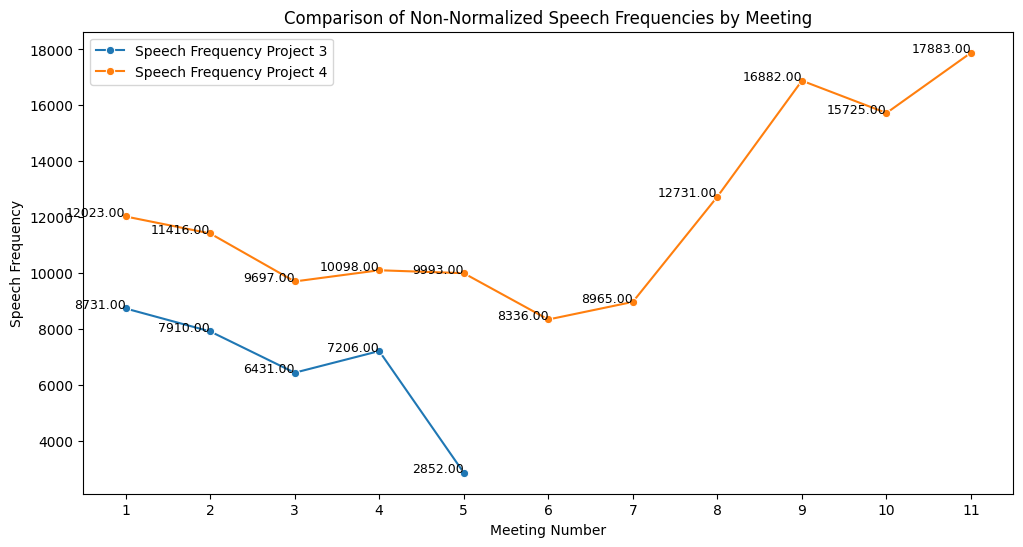

In [316]:
# Compare non-normalized speech frequencies by project
speech_comparison_df = speech_summary.groupby(['project', 'meeting_number'])['adjusted_speech_frequency'].sum().reset_index()
speech_comparison_df_pivot = speech_comparison_df.pivot(index='meeting_number', columns='project', values='adjusted_speech_frequency')
speech_comparison_df_pivot.columns = ['Speech_Frequency_Project3', 'Speech_Frequency_Project4']
speech_comparison_df_pivot.reset_index(inplace=True)

# Filter meeting numbers to include only those with data points for either project
meeting_numbers_with_data = speech_comparison_df_pivot[
    (speech_comparison_df_pivot['Speech_Frequency_Project3'] > 0) |
    (speech_comparison_df_pivot['Speech_Frequency_Project4'] > 0)
]['meeting_number']

plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number', y='Speech_Frequency_Project3', label='Speech Frequency Project 3', marker='o')
sns.lineplot(data=speech_comparison_df_pivot, x='meeting_number', y='Speech_Frequency_Project4', label='Speech Frequency Project 4', marker='o')
for i in range(len(speech_comparison_df_pivot)):
    if speech_comparison_df_pivot['Speech_Frequency_Project3'].iloc[i] > 0:
        plt.text(speech_comparison_df_pivot['meeting_number'].iloc[i], speech_comparison_df_pivot['Speech_Frequency_Project3'].iloc[i], f"{speech_comparison_df_pivot['Speech_Frequency_Project3'].iloc[i]:.2f}", fontsize=9, ha='right')
    if speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i] > 0:
        plt.text(speech_comparison_df_pivot['meeting_number'].iloc[i], speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i], f"{speech_comparison_df_pivot['Speech_Frequency_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
plt.xticks(ticks=meeting_numbers_with_data)

plt.title('Comparison of Non-Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Speech Frequency')
plt.legend()
plt.show()


## Plot Comparison of Non-Normalized Total Speech Frequencies by Each Speaker

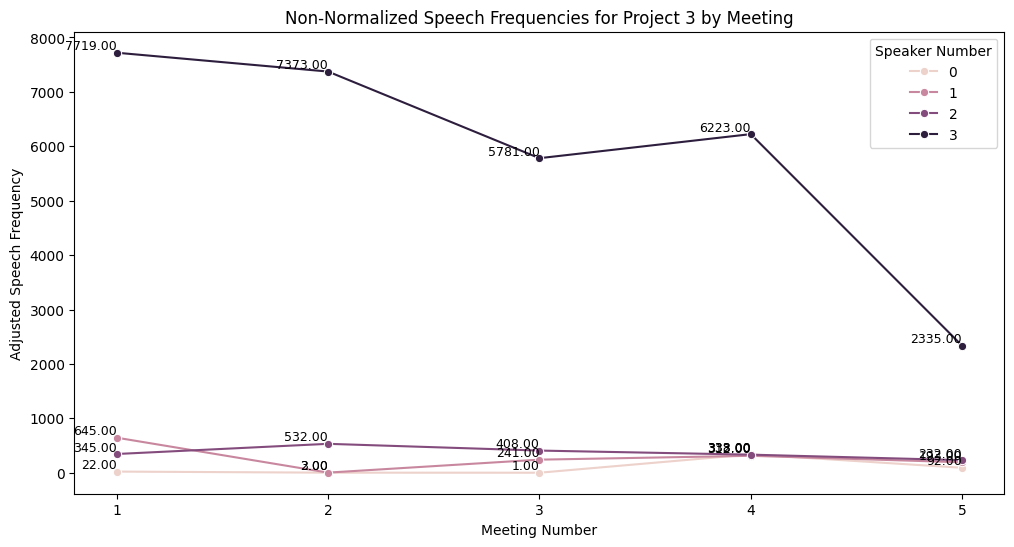

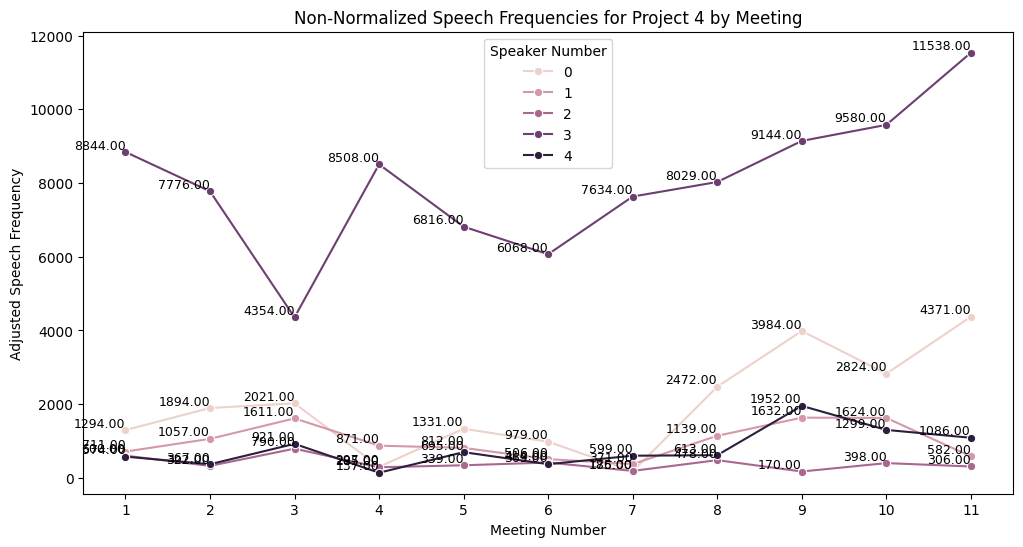

In [317]:
# Plot non-normalized speech frequencies by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_summary[speech_summary['project'] == 3], x='meeting_number', y='adjusted_speech_frequency', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(speech_summary[speech_summary['project'] == 3]['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for i in range(len(speech_summary[speech_summary['project'] == 3])):
    plt.text(speech_summary[speech_summary['project'] == 3]['meeting_number'].iloc[i], speech_summary[speech_summary['project'] == 3]['adjusted_speech_frequency'].iloc[i],
             f"{speech_summary[speech_summary['project'] == 3]['adjusted_speech_frequency'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Speech Frequencies for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Adjusted Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

# Plot non-normalized speech frequencies by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_summary[speech_summary['project'] == 4], x='meeting_number', y='adjusted_speech_frequency', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(speech_summary[speech_summary['project'] == 4]['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(speech_summary[speech_summary['project'] == 4])):
    plt.text(speech_summary[speech_summary['project'] == 4]['meeting_number'].iloc[i], speech_summary[speech_summary['project'] == 4]['adjusted_speech_frequency'].iloc[i],
             f"{speech_summary[speech_summary['project'] == 4]['adjusted_speech_frequency'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Adjusted Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Normalized Total Speech Frequencies

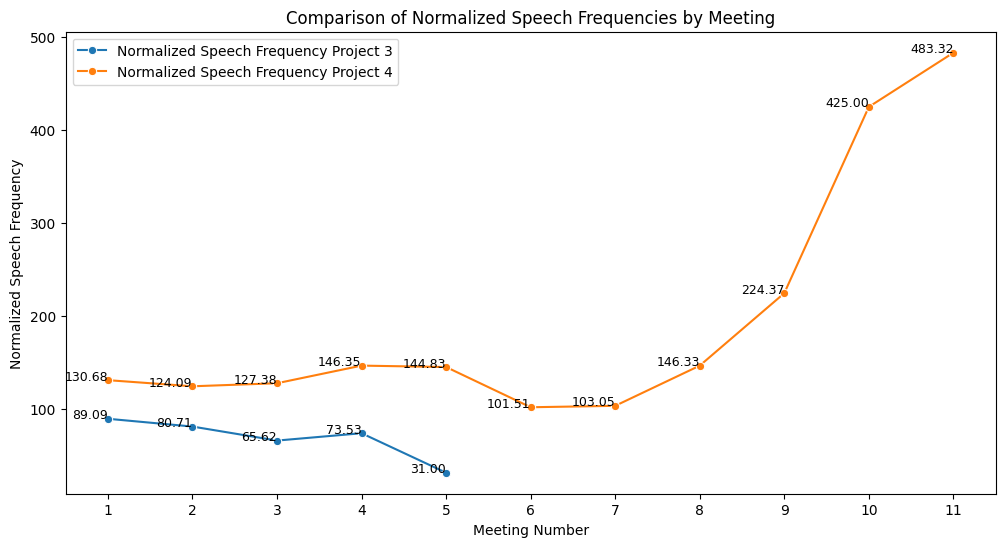

In [318]:
# Compare normalized speech frequencies by project
normalized_speech_comparison_df = speech_summary.groupby(['project', 'meeting_number'])['normalized_speech_frequency'].sum().reset_index()
normalized_speech_comparison_df_pivot = normalized_speech_comparison_df.pivot(index='meeting_number', columns='project', values='normalized_speech_frequency')
normalized_speech_comparison_df_pivot.columns = ['Normalized_Speech_Frequency_Project3', 'Normalized_Speech_Frequency_Project4']
normalized_speech_comparison_df_pivot.reset_index(inplace=True)

# Filter meeting numbers to include only those with data points for either project
meeting_numbers_with_data = normalized_speech_comparison_df_pivot[
    (normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'] > 0) |
    (normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'] > 0)
]['meeting_number']

plt.figure(figsize=(12, 6))
sns.lineplot(data=normalized_speech_comparison_df_pivot, x='meeting_number', y='Normalized_Speech_Frequency_Project3', label='Normalized Speech Frequency Project 3', marker='o')
sns.lineplot(data=normalized_speech_comparison_df_pivot, x='meeting_number', y='Normalized_Speech_Frequency_Project4', label='Normalized Speech Frequency Project 4', marker='o')
for i in range(len(normalized_speech_comparison_df_pivot)):
    if normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'].iloc[i] > 0:
        plt.text(normalized_speech_comparison_df_pivot['meeting_number'].iloc[i], normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'].iloc[i], f"{normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project3'].iloc[i]:.2f}", fontsize=9, ha='right')
    if normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i] > 0:
        plt.text(normalized_speech_comparison_df_pivot['meeting_number'].iloc[i], normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i], f"{normalized_speech_comparison_df_pivot['Normalized_Speech_Frequency_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
plt.xticks(ticks=meeting_numbers_with_data)

plt.title('Comparison of Normalized Speech Frequencies by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend()
plt.show()


## Plot Comparison of Normalized Total Speech Frequencies by Each Speaker

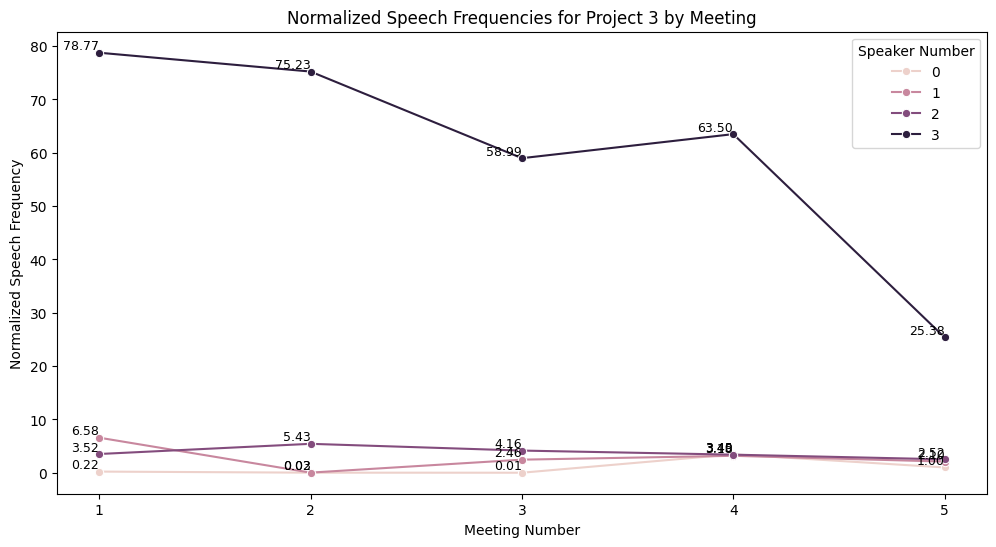

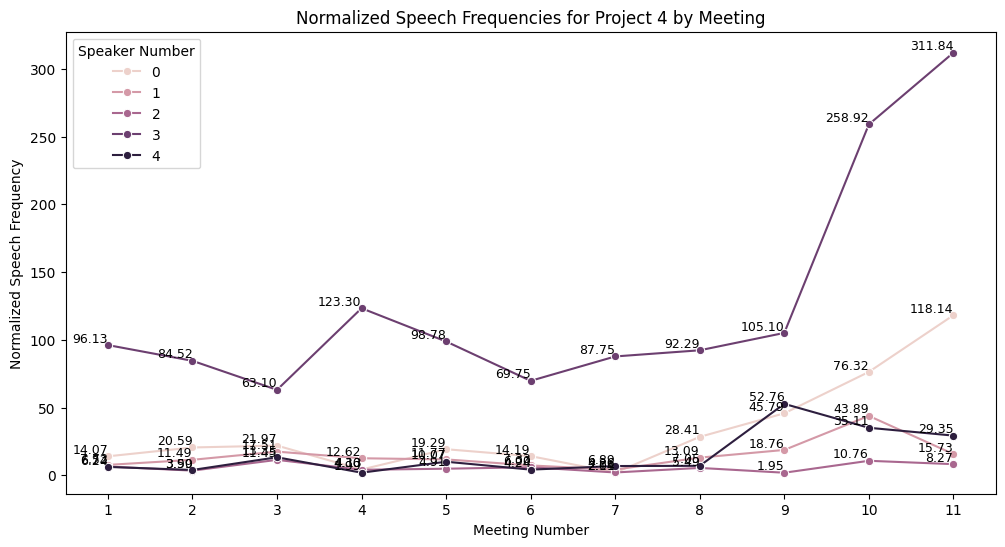

In [319]:
# Plot normalized speech frequencies by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_summary[speech_summary['project'] == 3], x='meeting_number', y='normalized_speech_frequency', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(speech_summary[speech_summary['project'] == 3]['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for i in range(len(speech_summary[speech_summary['project'] == 3])):
    plt.text(speech_summary[speech_summary['project'] == 3]['meeting_number'].iloc[i], speech_summary[speech_summary['project'] == 3]['normalized_speech_frequency'].iloc[i],
             f"{speech_summary[speech_summary['project'] == 3]['normalized_speech_frequency'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Normalized Speech Frequencies for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()

# Plot normalized speech frequencies by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=speech_summary[speech_summary['project'] == 4], x='meeting_number', y='normalized_speech_frequency', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(speech_summary[speech_summary['project'] == 4]['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(speech_summary[speech_summary['project'] == 4])):
    plt.text(speech_summary[speech_summary['project'] == 4]['meeting_number'].iloc[i], speech_summary[speech_summary['project'] == 4]['normalized_speech_frequency'].iloc[i],
             f"{speech_summary[speech_summary['project'] == 4]['normalized_speech_frequency'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Normalized Speech Frequencies for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Speech Frequency')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Non-Normalized Total Interactions

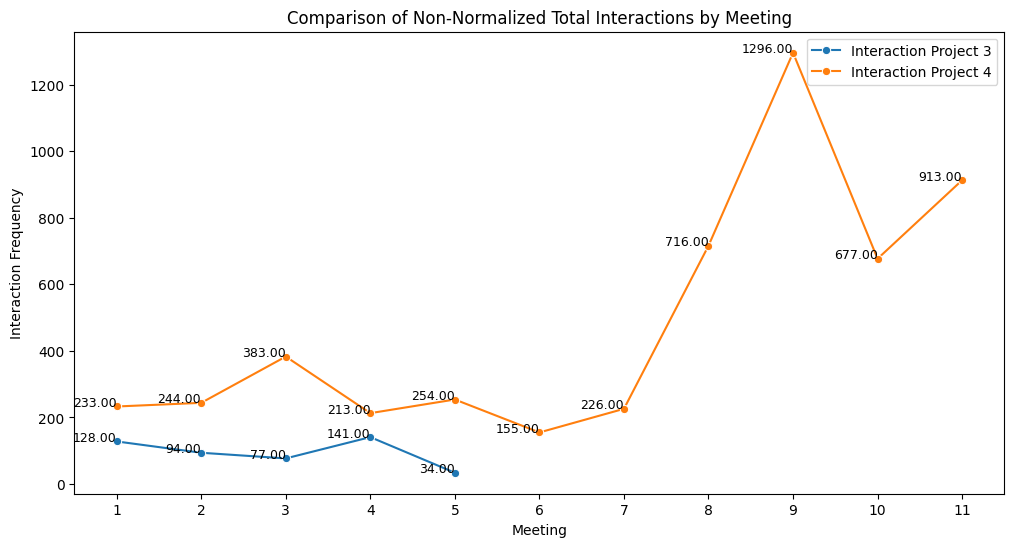

In [320]:
# Compute Interaction Frequencies Excluding Self-Interactions
interaction_frequencies_project3 = interaction_summary[interaction_summary['project'] == 3].groupby('meeting_number')['count'].sum().reset_index()
interaction_frequencies_project4 = interaction_summary[interaction_summary['project'] == 4].groupby('meeting_number')['count'].sum().reset_index()

# Compare interaction frequencies by nth meeting
comparison_df = pd.DataFrame({
    'Meeting': range(1, max(len(interaction_frequencies_project3), len(interaction_frequencies_project4)) + 1),
    'Interaction_Project3': interaction_frequencies_project3.set_index('meeting_number')['count'],
    'Interaction_Project4': interaction_frequencies_project4.set_index('meeting_number')['count']
}).reset_index(drop=True)

# Plot comparison of interaction frequencies
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project3', label='Interaction Project 3', marker='o')
sns.lineplot(data=comparison_df, x='Meeting', y='Interaction_Project4', label='Interaction Project 4', marker='o')
for i in range(len(comparison_df)):
    if comparison_df['Interaction_Project3'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Interaction_Project3'].iloc[i], f"{comparison_df['Interaction_Project3'].iloc[i]:.2f}", fontsize=9, ha='right')
    if comparison_df['Interaction_Project4'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Interaction_Project4'].iloc[i], f"{comparison_df['Interaction_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = comparison_df[(comparison_df['Interaction_Project3'] > 0) | (comparison_df['Interaction_Project4'] > 0)]['Meeting']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Non-Normalized Total Interactions by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Interaction Frequency')
plt.legend()
plt.show()


## Plot Comparison of Non-Normalized Total Interactions by Each Speaker

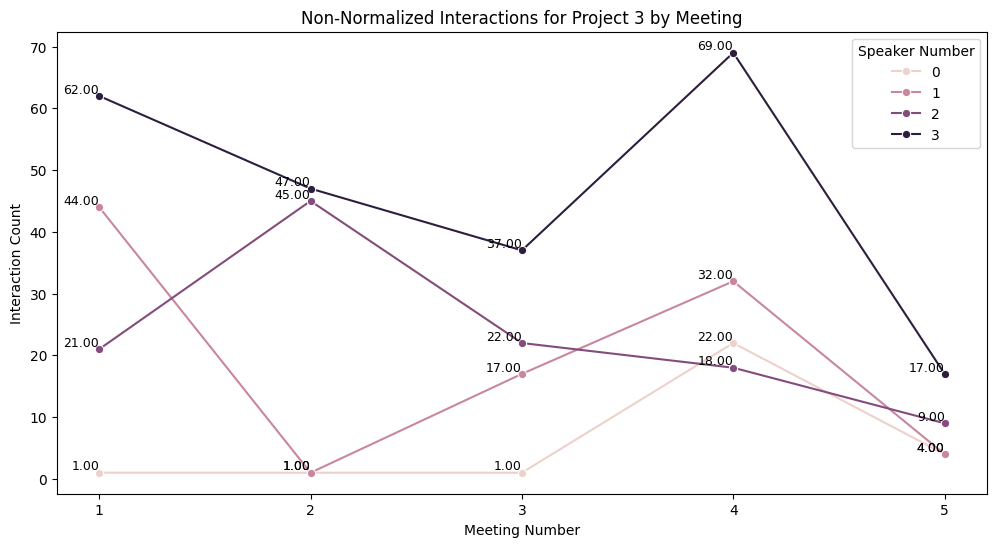

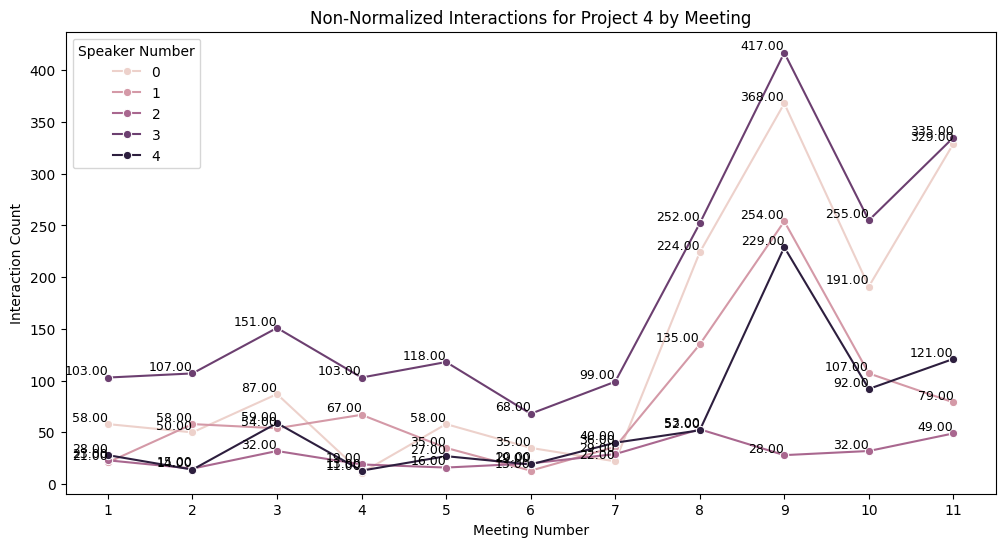

In [321]:
# Exclude self-interactions and summarize interactions for Project 3
summary_project_3 = interaction_summary[interaction_summary['project'] == 3].groupby(['meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Plot non-normalized interactions by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_3, x='meeting_number', y='count', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(summary_project_3['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for i in range(len(summary_project_3)):
    plt.text(summary_project_3['meeting_number'].iloc[i], summary_project_3['count'].iloc[i],
             f"{summary_project_3['count'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Interactions for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Interaction Count')
plt.legend(title='Speaker Number')
plt.show()

# Exclude self-interactions and summarize interactions for Project 4
summary_project_4 = interaction_summary[interaction_summary['project'] == 4].groupby(['meeting_number', 'speaker_number'])['count'].sum().reset_index()

# Plot non-normalized interactions by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_project_4, x='meeting_number', y='count', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(summary_project_4['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(summary_project_4)):
    plt.text(summary_project_4['meeting_number'].iloc[i], summary_project_4['count'].iloc[i],
             f"{summary_project_4['count'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Non-Normalized Interactions for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Interaction Count')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Normalized Total Interactions

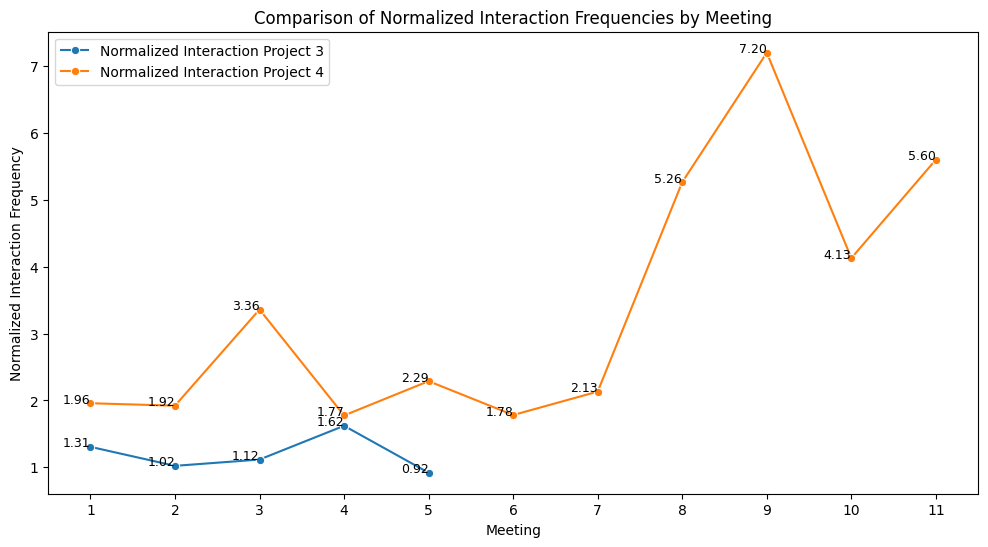

In [322]:
# Compute Interaction Frequencies Excluding Self-Interactions for each project
interaction_frequencies_project3 = interaction_summary[interaction_summary['project'] == 3].groupby(['meeting_number'])['normalized_interaction_count'].sum().reset_index()
interaction_frequencies_project4 = interaction_summary[interaction_summary['project'] == 4].groupby(['meeting_number'])['normalized_interaction_count'].sum().reset_index()

# Compare normalized interaction frequencies by nth meeting
comparison_df = pd.DataFrame({
    'Meeting': range(1, max(len(interaction_frequencies_project3), len(interaction_frequencies_project4)) + 1),
    'Normalized_Interaction_Project3': interaction_frequencies_project3.set_index('meeting_number')['normalized_interaction_count'],
    'Normalized_Interaction_Project4': interaction_frequencies_project4.set_index('meeting_number')['normalized_interaction_count']
}).reset_index(drop=True)

# Plot comparison of normalized interaction frequencies
plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project3', label='Normalized Interaction Project 3', marker='o')
sns.lineplot(data=comparison_df, x='Meeting', y='Normalized_Interaction_Project4', label='Normalized Interaction Project 4', marker='o')
for i in range(len(comparison_df)):
    if comparison_df['Normalized_Interaction_Project3'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Normalized_Interaction_Project3'].iloc[i], f"{comparison_df['Normalized_Interaction_Project3'].iloc[i]:.2f}", fontsize=9, ha='right')
    if comparison_df['Normalized_Interaction_Project4'].iloc[i] > 0:
        plt.text(comparison_df['Meeting'].iloc[i], comparison_df['Normalized_Interaction_Project4'].iloc[i], f"{comparison_df['Normalized_Interaction_Project4'].iloc[i]:.2f}", fontsize=9, ha='right')

# Set x-ticks to only those meetings with data points for either project 3 or project 4
meetings_with_data = comparison_df[(comparison_df['Normalized_Interaction_Project3'] > 0) | (comparison_df['Normalized_Interaction_Project4'] > 0)]['Meeting']
plt.xticks(ticks=meetings_with_data)

plt.title('Comparison of Normalized Interaction Frequencies by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Normalized Interaction Frequency')
plt.legend()
plt.show()


## Plot Comparison of Normalized Total Interactions by Each Speaker

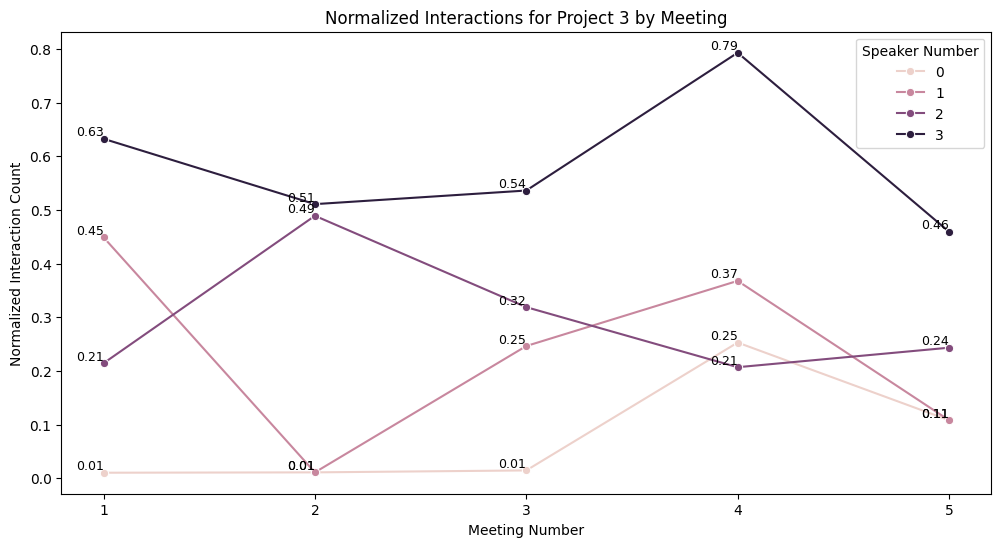

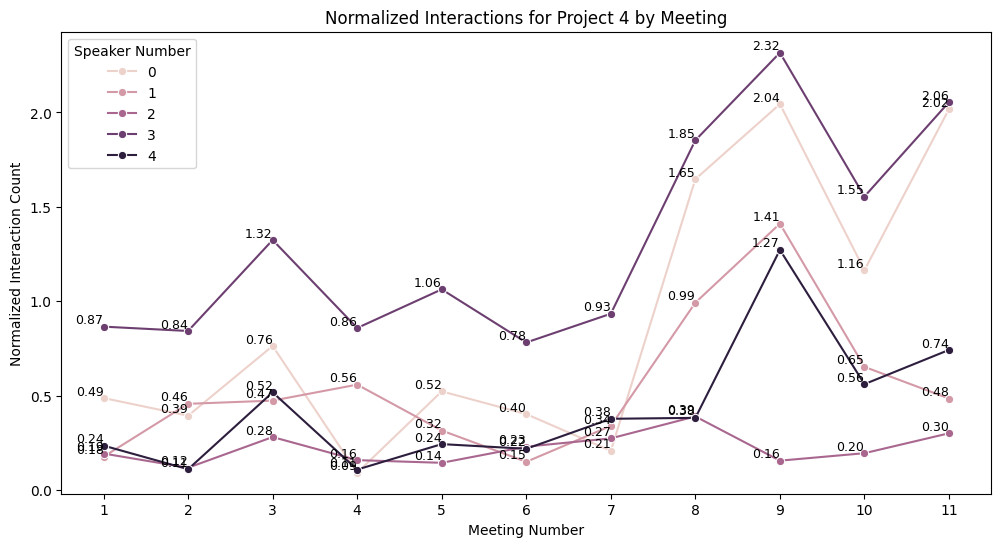

In [323]:
# Plot normalized interactions by each speaker for Project 3
plt.figure(figsize=(12, 6))
sns.lineplot(data=interaction_summary[interaction_summary['project'] == 3], x='meeting_number', y='normalized_interaction_count', hue='speaker_number', marker='o')
ticks_project_3 = sorted(set(interaction_summary[interaction_summary['project'] == 3]['meeting_number']))
plt.xticks(ticks=ticks_project_3)
for i in range(len(interaction_summary[interaction_summary['project'] == 3])):
    plt.text(interaction_summary[interaction_summary['project'] == 3]['meeting_number'].iloc[i], interaction_summary[interaction_summary['project'] == 3]['normalized_interaction_count'].iloc[i],
             f"{interaction_summary[interaction_summary['project'] == 3]['normalized_interaction_count'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Normalized Interactions for Project 3 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Interaction Count')
plt.legend(title='Speaker Number')
plt.show()

# Plot normalized interactions by each speaker for Project 4
plt.figure(figsize=(12, 6))
sns.lineplot(data=interaction_summary[interaction_summary['project'] == 4], x='meeting_number', y='normalized_interaction_count', hue='speaker_number', marker='o')
ticks_project_4 = sorted(set(interaction_summary[interaction_summary['project'] == 4]['meeting_number']))
plt.xticks(ticks=ticks_project_4)
for i in range(len(interaction_summary[interaction_summary['project'] == 4])):
    plt.text(interaction_summary[interaction_summary['project'] == 4]['meeting_number'].iloc[i], interaction_summary[interaction_summary['project'] == 4]['normalized_interaction_count'].iloc[i],
             f"{interaction_summary[interaction_summary['project'] == 4]['normalized_interaction_count'].iloc[i]:.2f}", fontsize=9, ha='right', va='bottom')
plt.title('Normalized Interactions for Project 4 by Meeting')
plt.xlabel('Meeting Number')
plt.ylabel('Normalized Interaction Count')
plt.legend(title='Speaker Number')
plt.show()


## Plot Comparison of Network Densities

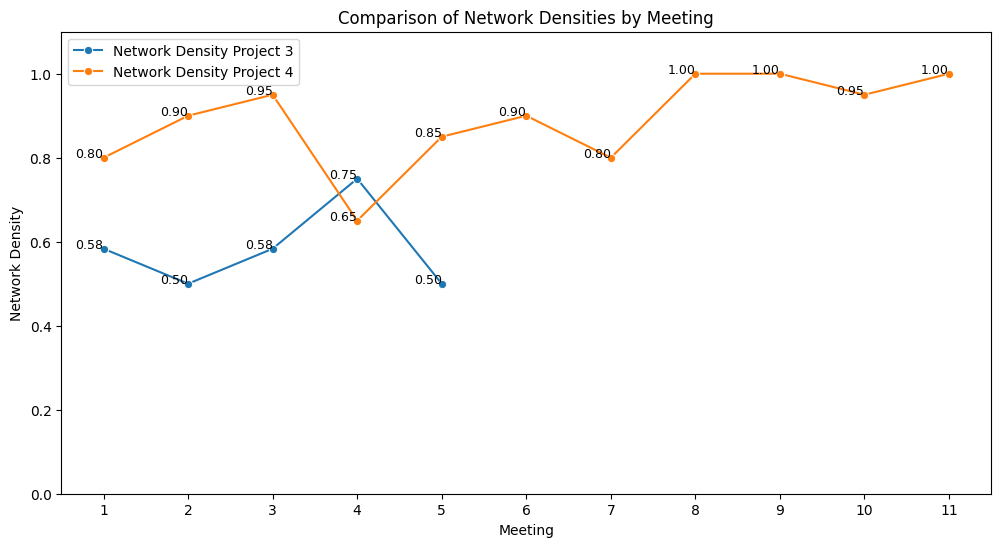

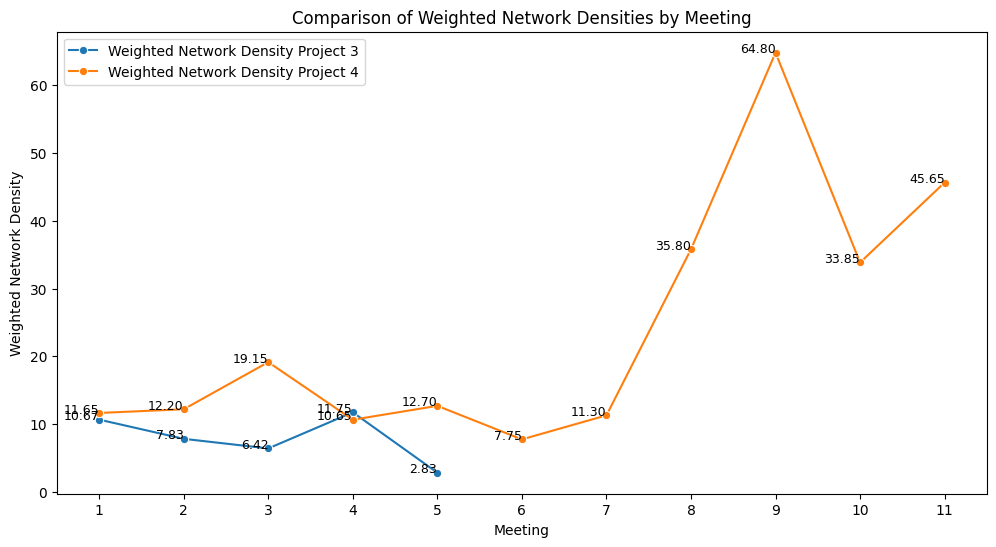

In [324]:
# Extract unique network densities and weighted network densities for each project
densities_project3 = dataset[dataset['project'] == 3].groupby('meeting_number')['network_density'].unique().apply(lambda x: x[0])
densities_project4 = dataset[dataset['project'] == 4].groupby('meeting_number')['network_density'].unique().apply(lambda x: x[0])

weighted_densities_project3 = dataset[dataset['project'] == 3].groupby('meeting_number')['weighted_network_density'].unique().apply(lambda x: x[0])
weighted_densities_project4 = dataset[dataset['project'] == 4].groupby('meeting_number')['weighted_network_density'].unique().apply(lambda x: x[0])

# Plot comparison of network densities
plt.figure(figsize=(12, 6))
df_project3 = pd.DataFrame({'Meeting': range(1, len(densities_project3) + 1), 'Network Density': densities_project3})
df_project4 = pd.DataFrame({'Meeting': range(1, len(densities_project4) + 1), 'Network Density': densities_project4})

sns.lineplot(data=df_project3, x='Meeting', y='Network Density', label='Network Density Project 3', marker='o')
sns.lineplot(data=df_project4, x='Meeting', y='Network Density', label='Network Density Project 4', marker='o')

for i in range(len(df_project3)):
    if df_project3['Network Density'].iloc[i] > 0:
        plt.text(df_project3['Meeting'].iloc[i], df_project3['Network Density'].iloc[i], f"{df_project3['Network Density'].iloc[i]:.2f}", fontsize=9, ha='right')
for i in range(len(df_project4)):
    if df_project4['Network Density'].iloc[i] > 0:
        plt.text(df_project4['Meeting'].iloc[i], df_project4['Network Density'].iloc[i], f"{df_project4['Network Density'].iloc[i]:.2f}", fontsize=9, ha='right')

plt.ylim(0, 1.1)
plt.xticks(ticks=range(1, max(len(df_project3), len(df_project4)) + 1))
plt.title('Comparison of Network Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Network Density')
plt.legend()
plt.show()

# Plot comparison of weighted network densities
plt.figure(figsize=(12, 6))
df_weighted_project3 = pd.DataFrame({'Meeting': range(1, len(weighted_densities_project3) + 1), 'Weighted Network Density': weighted_densities_project3})
df_weighted_project4 = pd.DataFrame({'Meeting': range(1, len(weighted_densities_project4) + 1), 'Weighted Network Density': weighted_densities_project4})

sns.lineplot(data=df_weighted_project3, x='Meeting', y='Weighted Network Density', label='Weighted Network Density Project 3', marker='o')
sns.lineplot(data=df_weighted_project4, x='Meeting', y='Weighted Network Density', label='Weighted Network Density Project 4', marker='o')

for i in range(len(df_weighted_project3)):
    if df_weighted_project3['Weighted Network Density'].iloc[i] > 0:
        plt.text(df_weighted_project3['Meeting'].iloc[i], df_weighted_project3['Weighted Network Density'].iloc[i], f"{df_weighted_project3['Weighted Network Density'].iloc[i]:.2f}", fontsize=9, ha='right')
for i in range(len(df_weighted_project4)):
    if df_weighted_project4['Weighted Network Density'].iloc[i] > 0:
        plt.text(df_weighted_project4['Meeting'].iloc[i], df_weighted_project4['Weighted Network Density'].iloc[i], f"{df_weighted_project4['Weighted Network Density'].iloc[i]:.2f}", fontsize=9, ha='right')

plt.xticks(ticks=range(1, max(len(df_weighted_project3), len(df_weighted_project4)) + 1))
plt.title('Comparison of Weighted Network Densities by Meeting')
plt.xlabel('Meeting')
plt.ylabel('Weighted Network Density')
plt.legend()
plt.show()


## Plot Comparison of Centralities

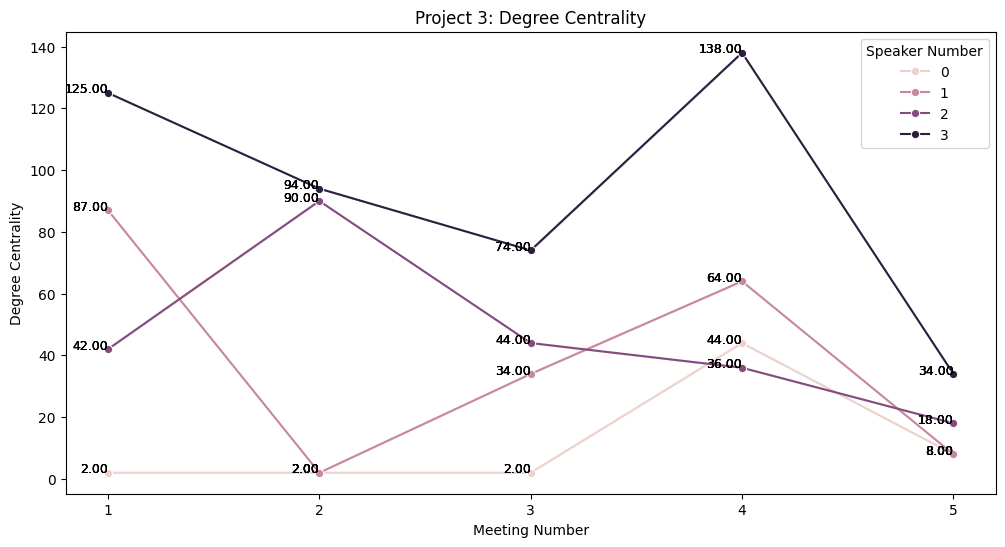

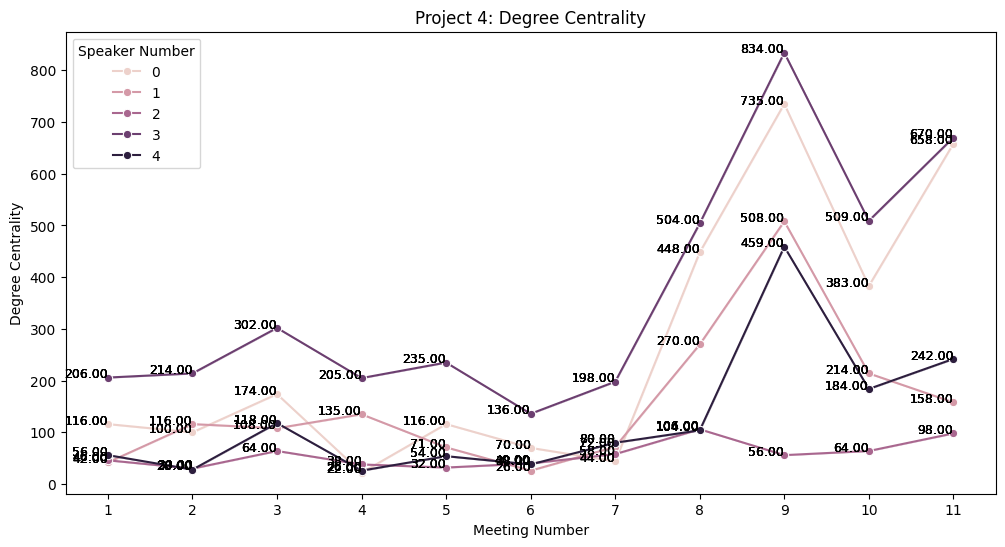

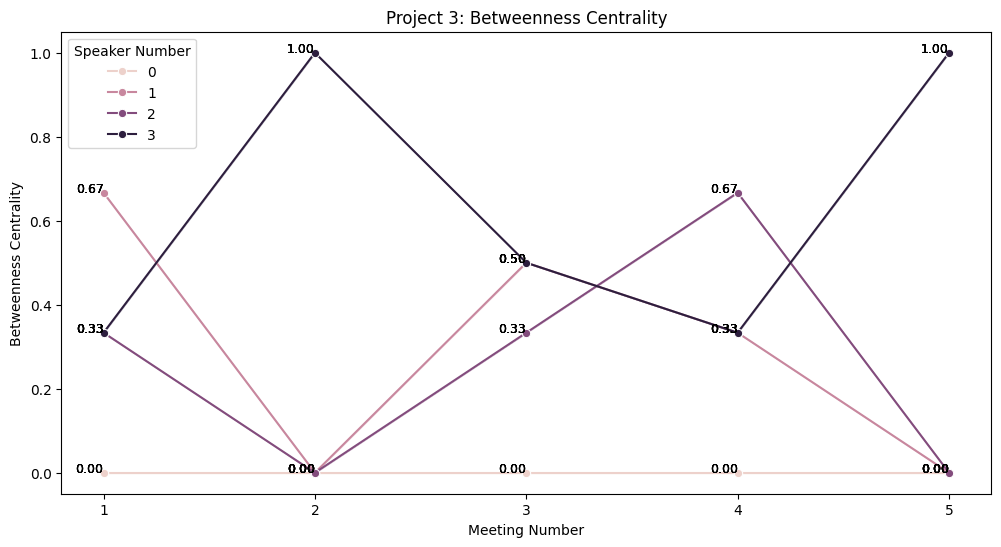

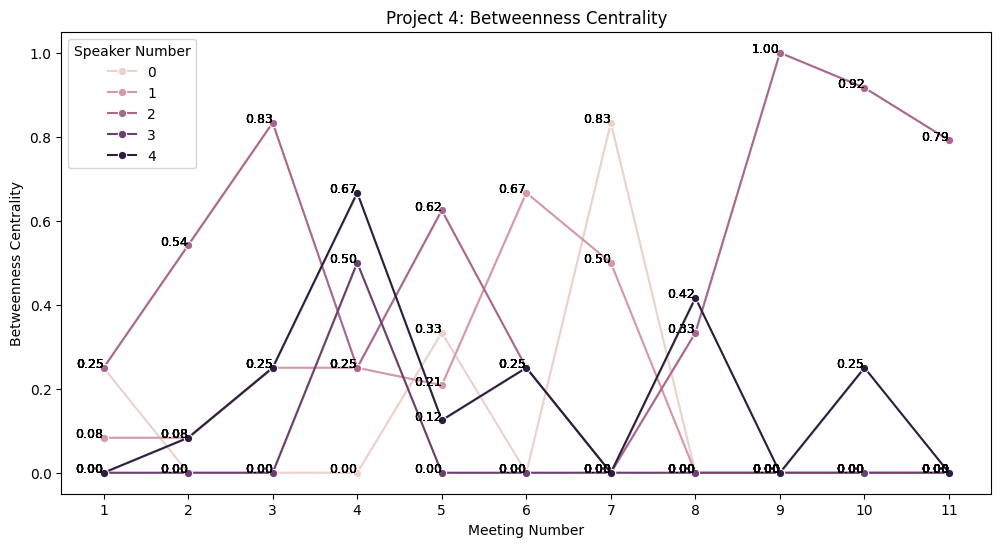

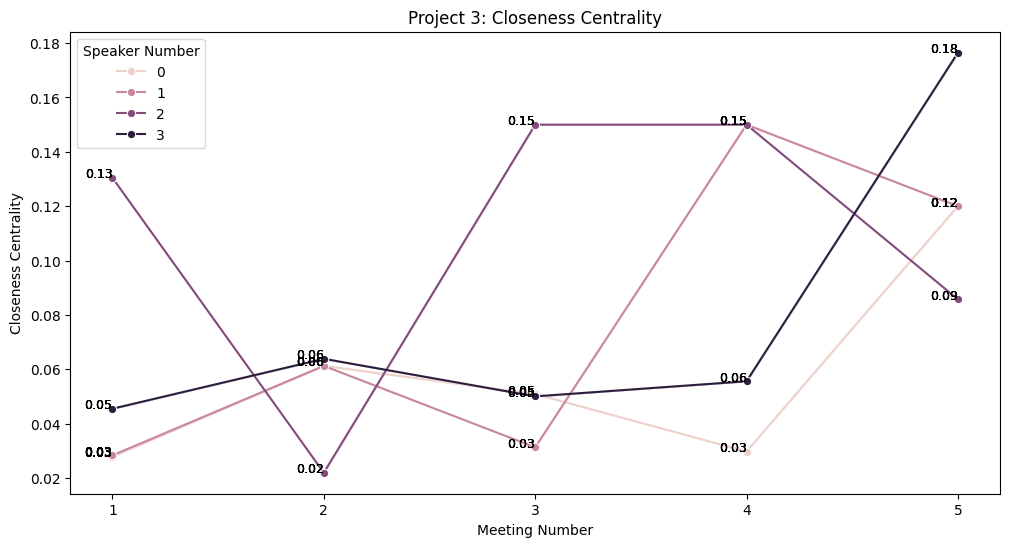

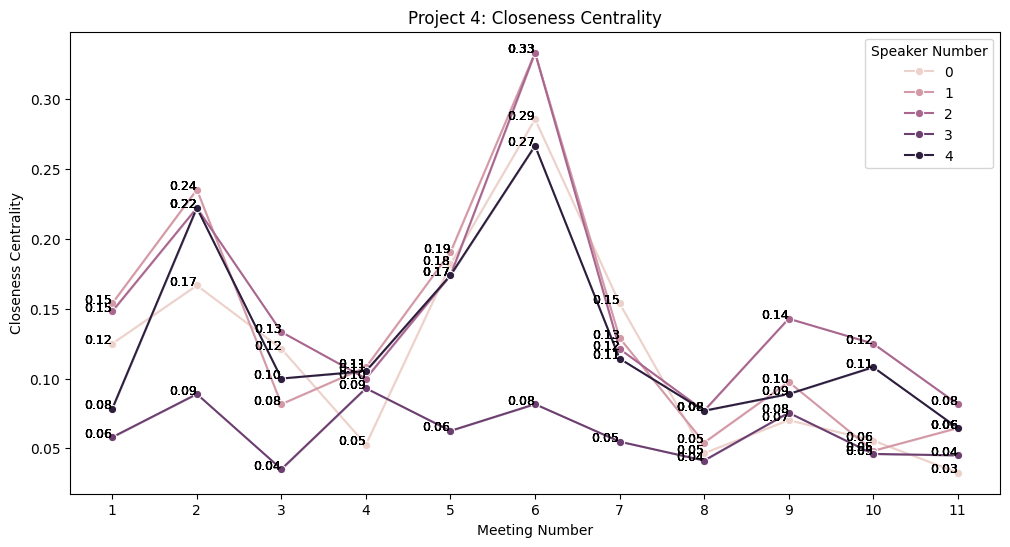

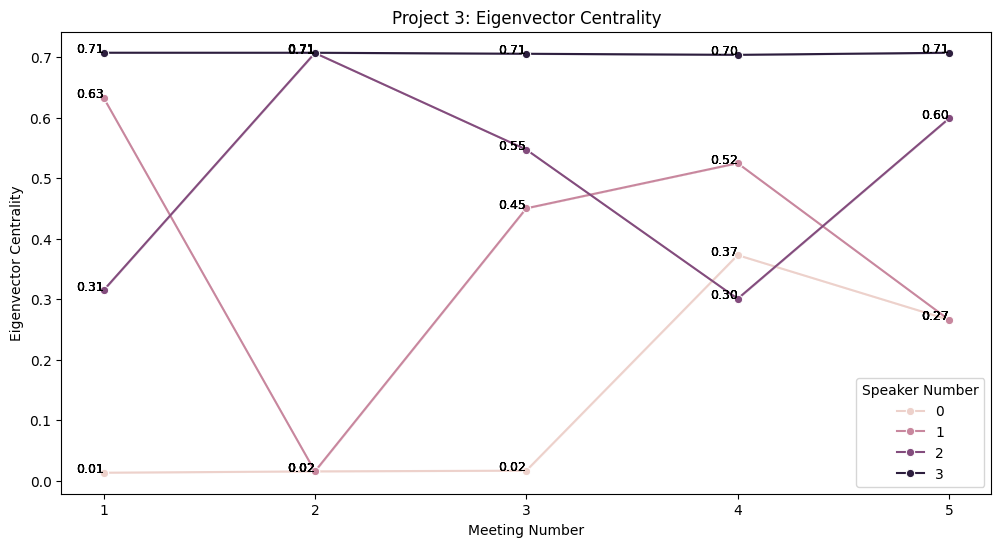

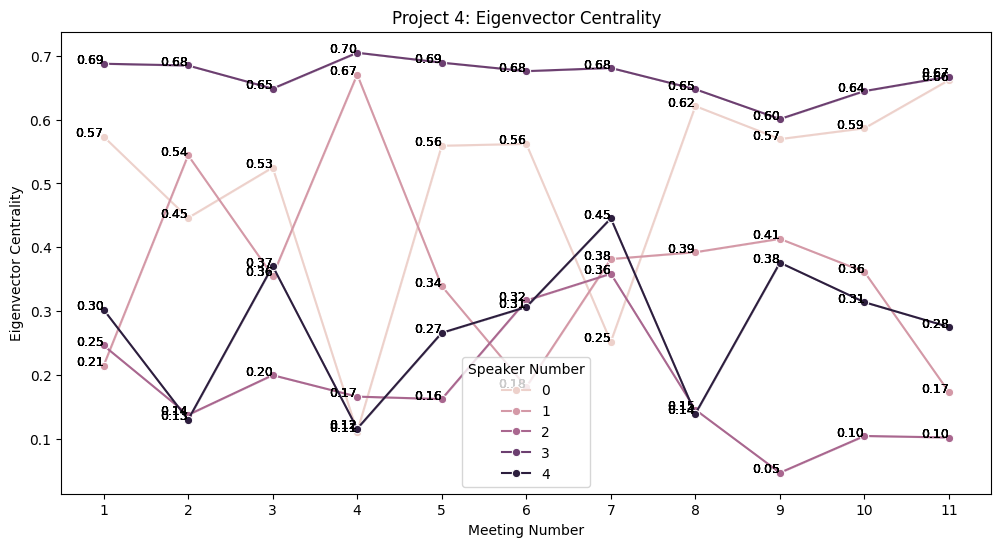

In [325]:
# Define function to plot centrality measures by speaker
def plot_centrality_measures_by_speaker(dataset, measure, title):
    plt.figure(figsize=(12, 6))
    project_3_data = dataset[dataset['project'] == 3]
    sns.lineplot(data=project_3_data, x='meeting_number', y=measure, hue='speaker_number', marker='o', legend='full')
    for speaker in project_3_data['speaker_number'].unique():
        speaker_data = project_3_data[project_3_data['speaker_number'] == speaker]
        for i in range(len(speaker_data)):
            plt.text(speaker_data['meeting_number'].iloc[i], speaker_data[measure].iloc[i], f"{speaker_data[measure].iloc[i]:.2f}", fontsize=9, ha='right')
    plt.xticks(ticks=project_3_data['meeting_number'].unique())
    plt.title(f'Project 3: {title}')
    plt.xlabel('Meeting Number')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend(title='Speaker Number')
    plt.show()

    plt.figure(figsize=(12, 6))
    project_4_data = dataset[dataset['project'] == 4]
    sns.lineplot(data=project_4_data, x='meeting_number', y=measure, hue='speaker_number', marker='o', legend='full')
    for speaker in project_4_data['speaker_number'].unique():
        speaker_data = project_4_data[project_4_data['speaker_number'] == speaker]
        for i in range(len(speaker_data)):
            plt.text(speaker_data['meeting_number'].iloc[i], speaker_data[measure].iloc[i], f"{speaker_data[measure].iloc[i]:.2f}", fontsize=9, ha='right')
    plt.xticks(ticks=project_4_data['meeting_number'].unique())
    plt.title(f'Project 4: {title}')
    plt.xlabel('Meeting Number')
    plt.ylabel(measure.replace('_', ' ').title())
    plt.legend(title='Speaker Number')
    plt.show()

# Plot comparison of centralities by speaker
centrality_measures = ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
titles = ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']

for measure, title in zip(centrality_measures, titles):
    plot_centrality_measures_by_speaker(dataset, measure, title)

## Plot Interaction Network Graph

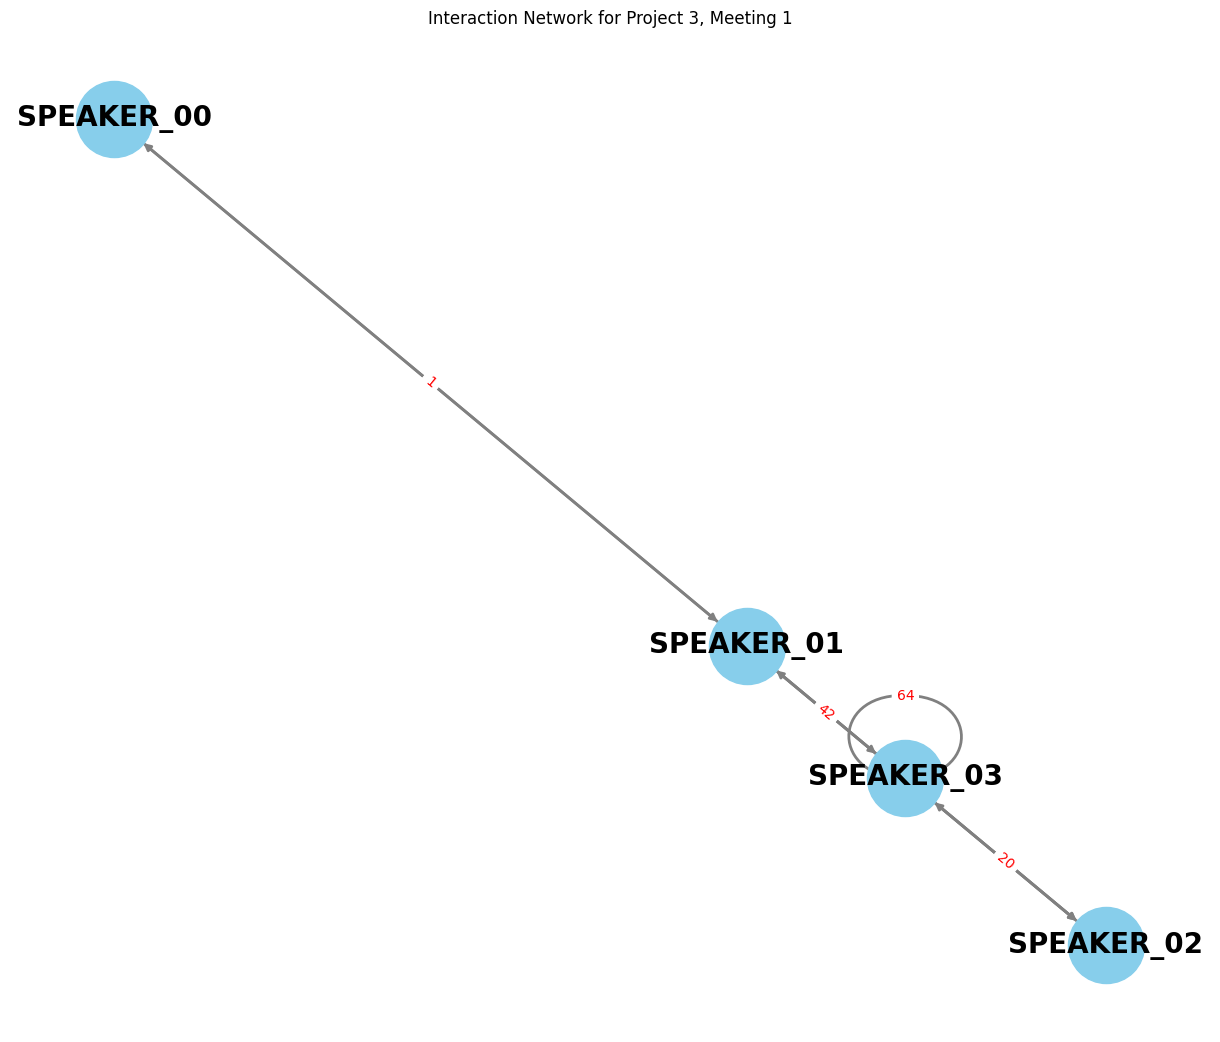

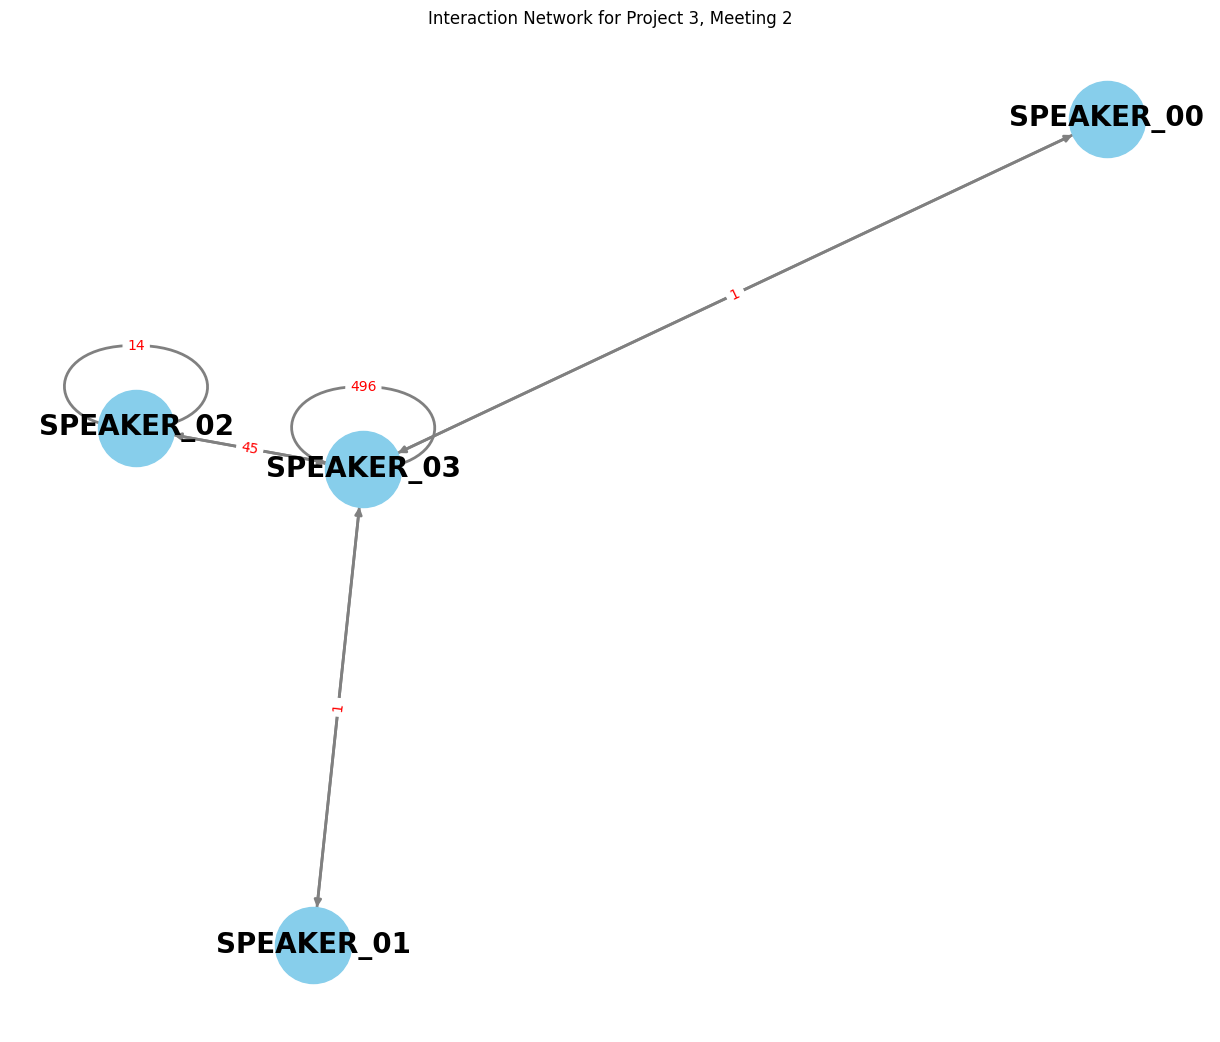

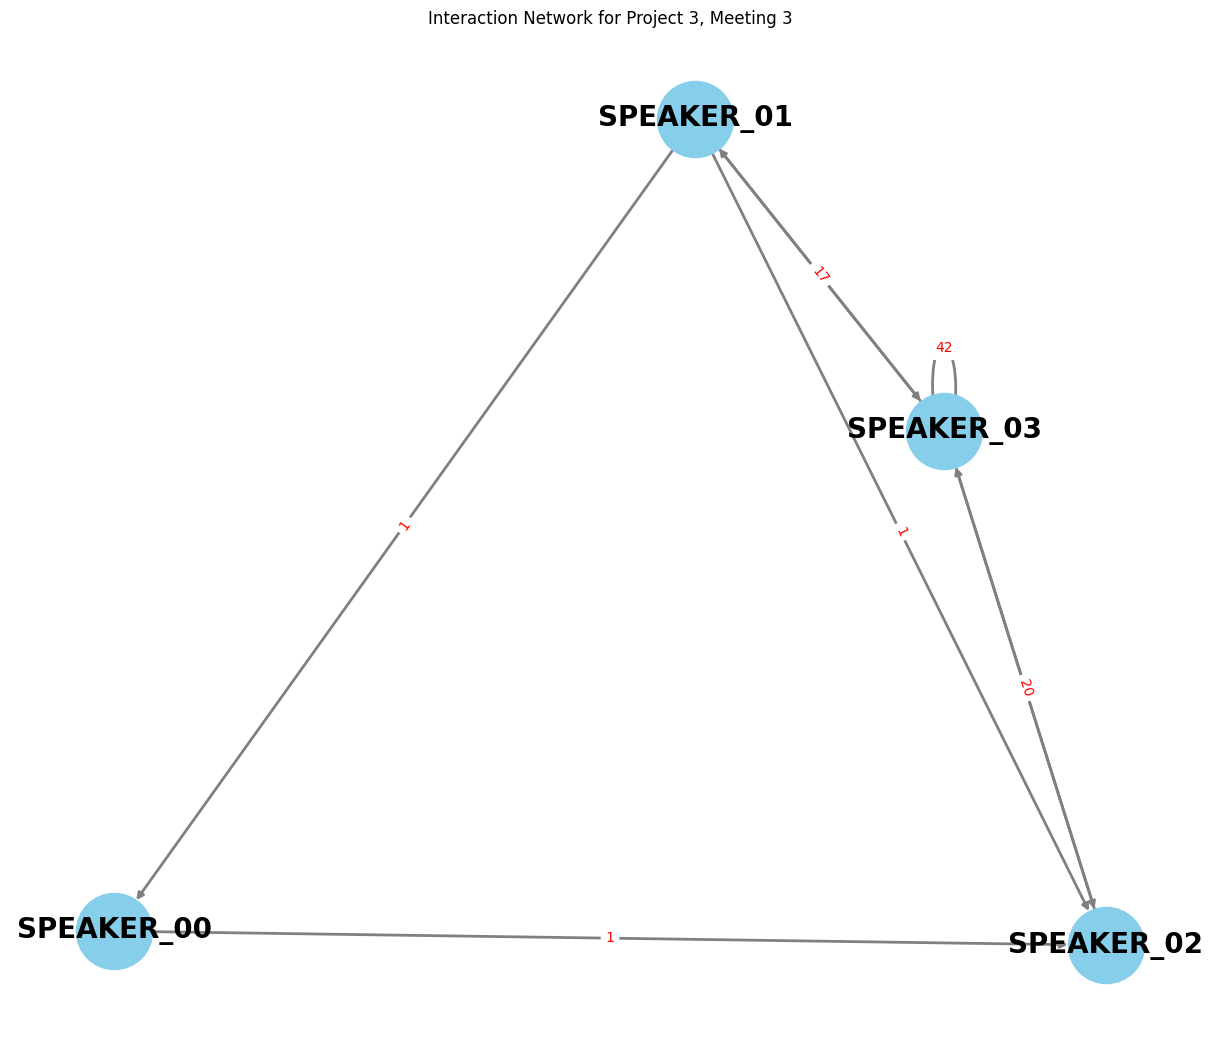

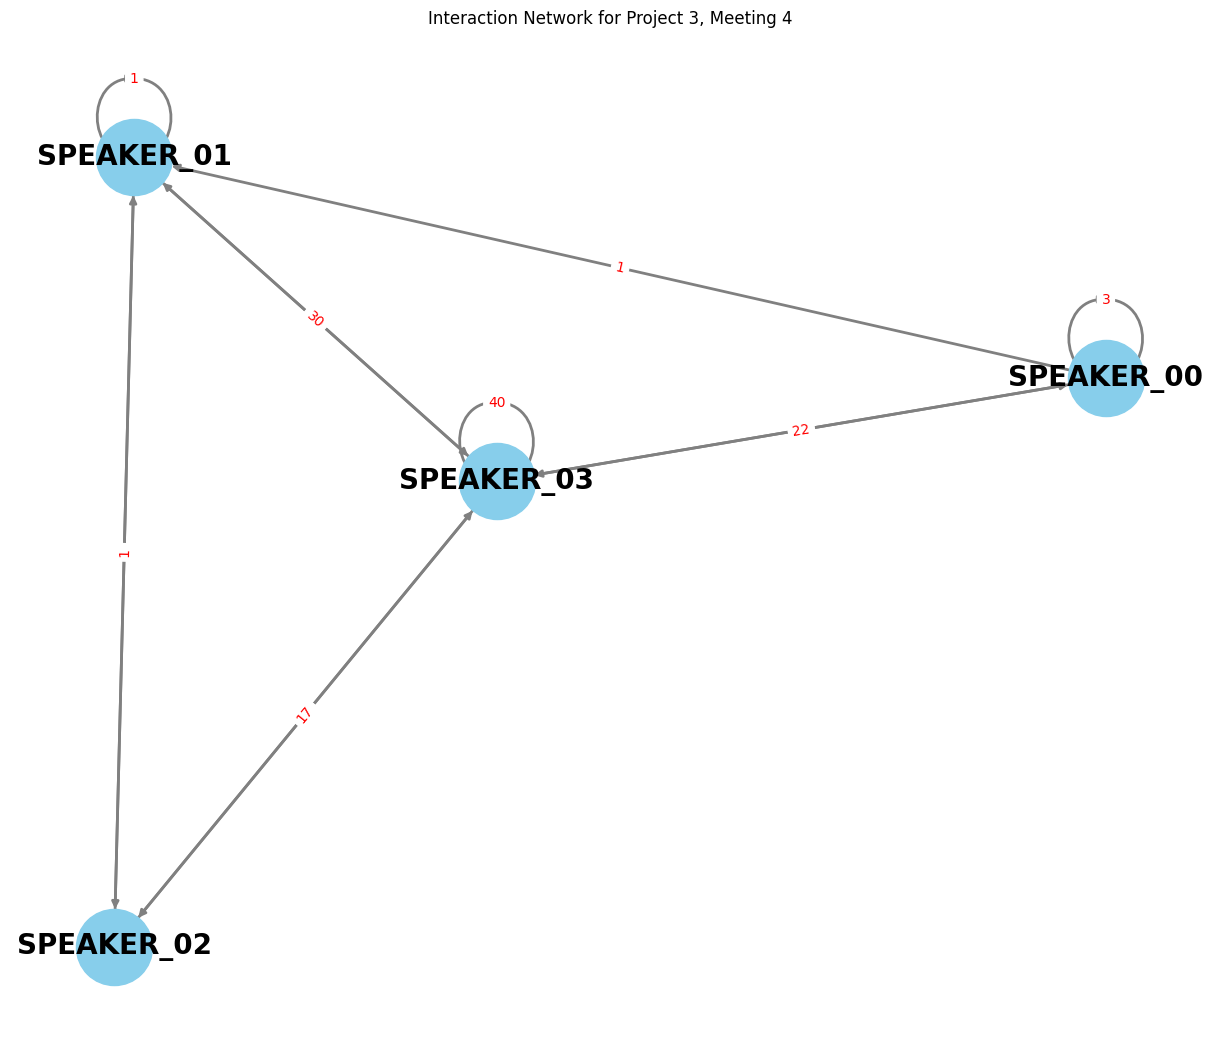

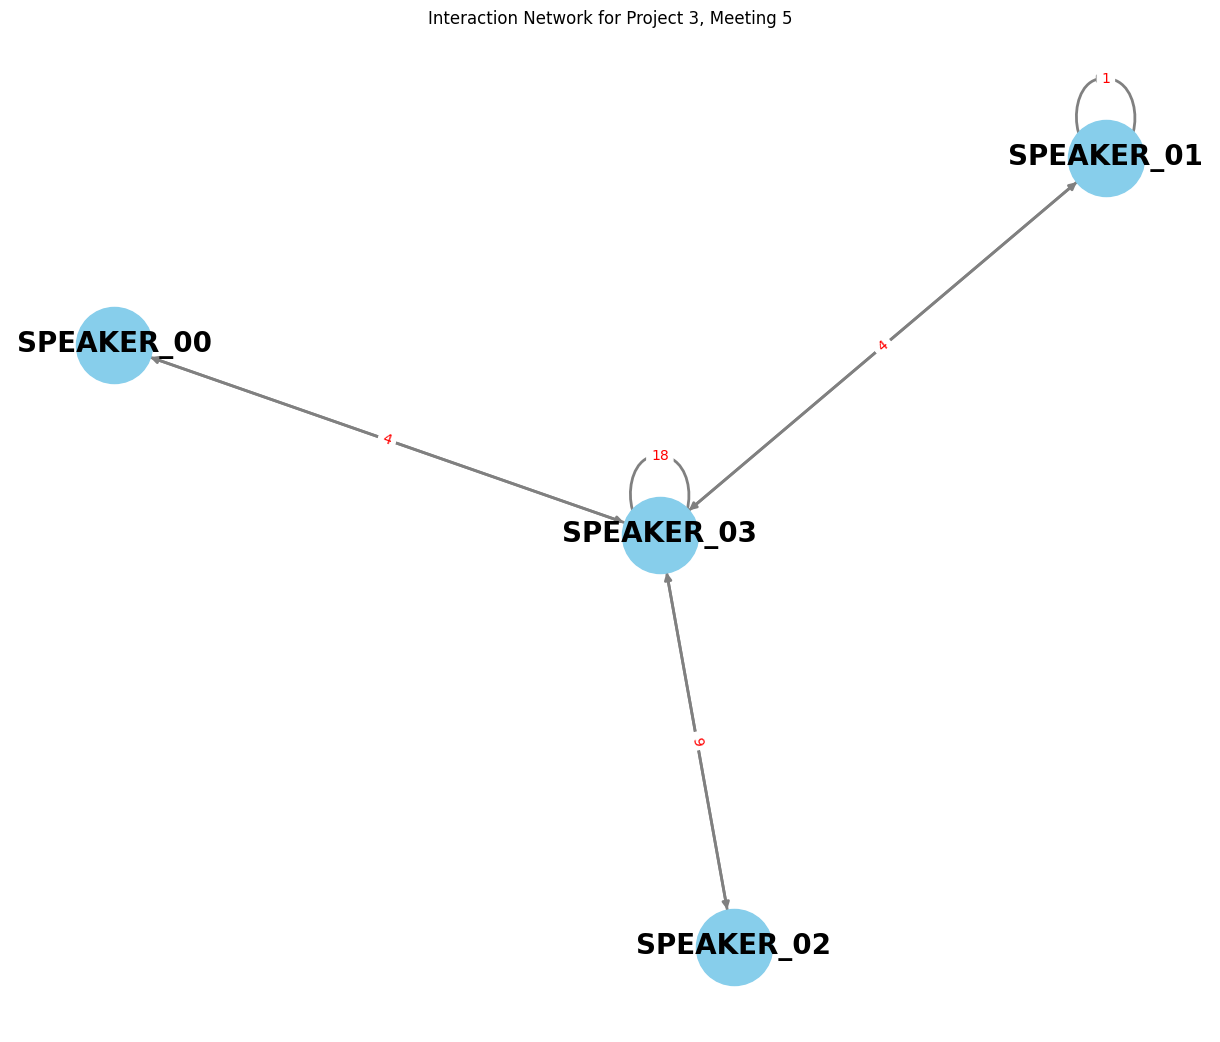

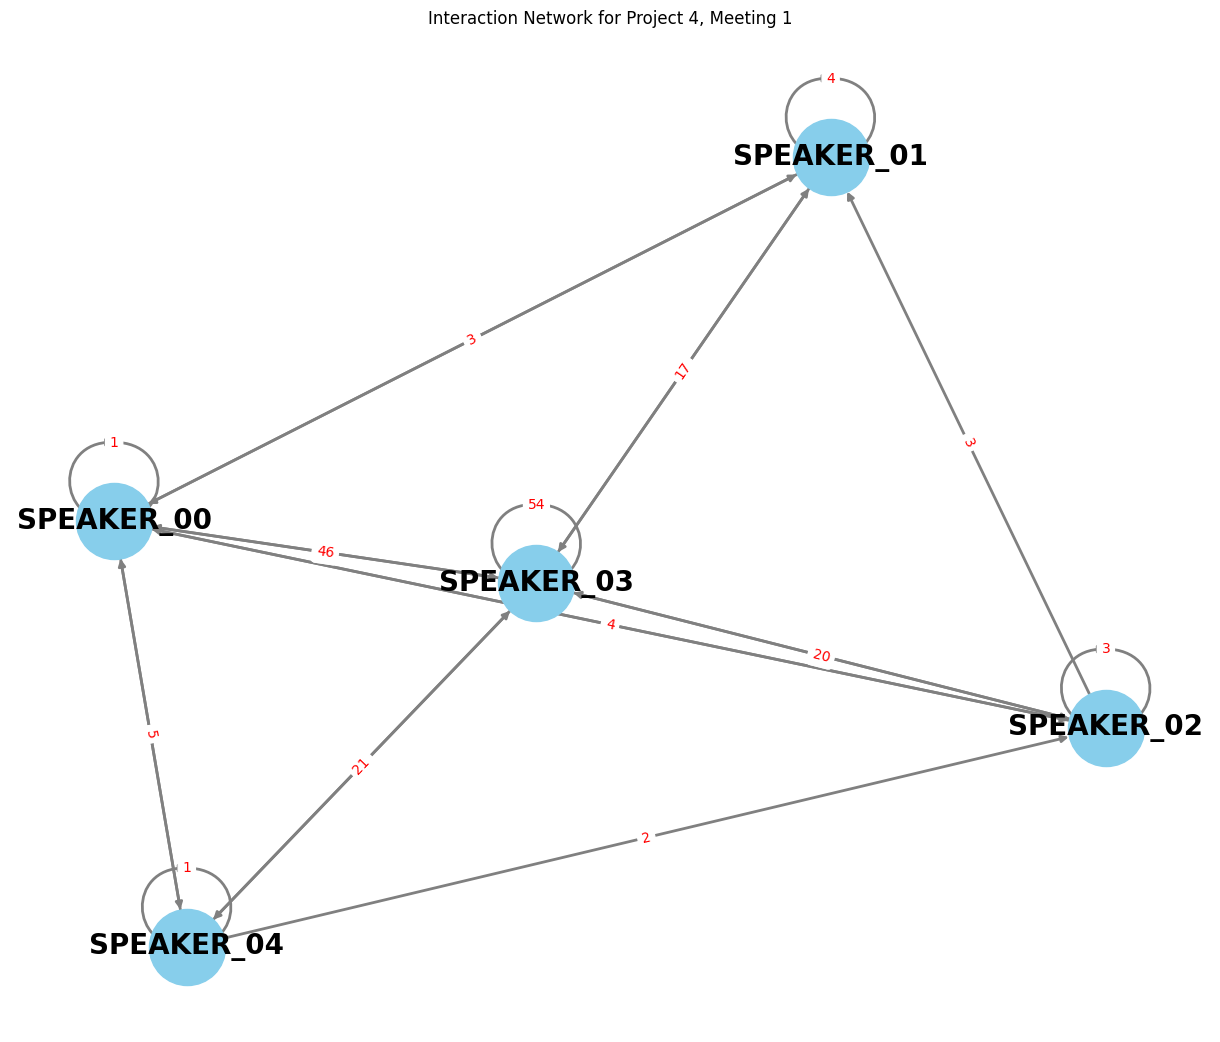

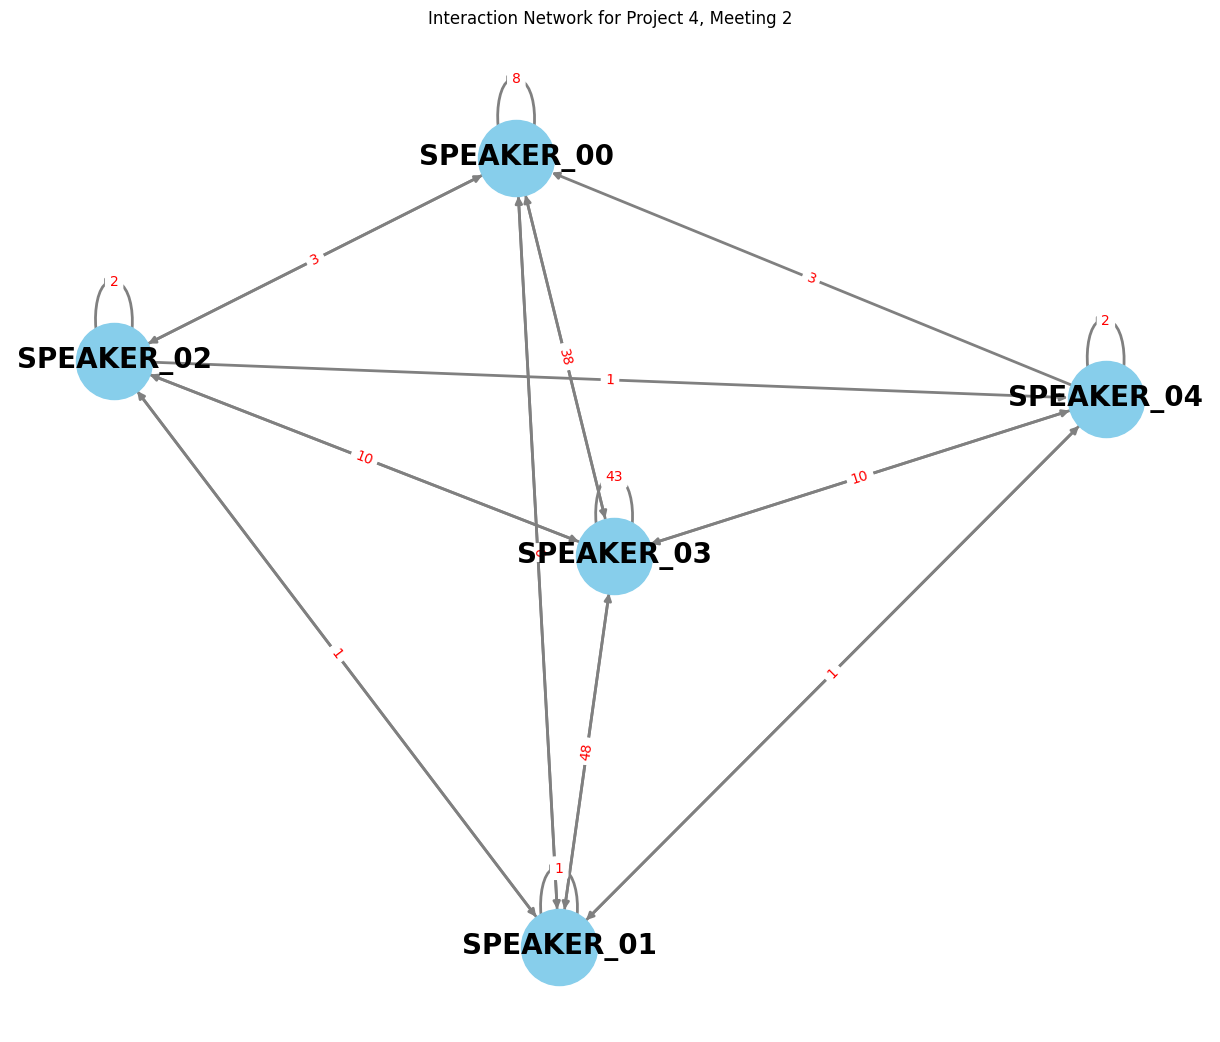

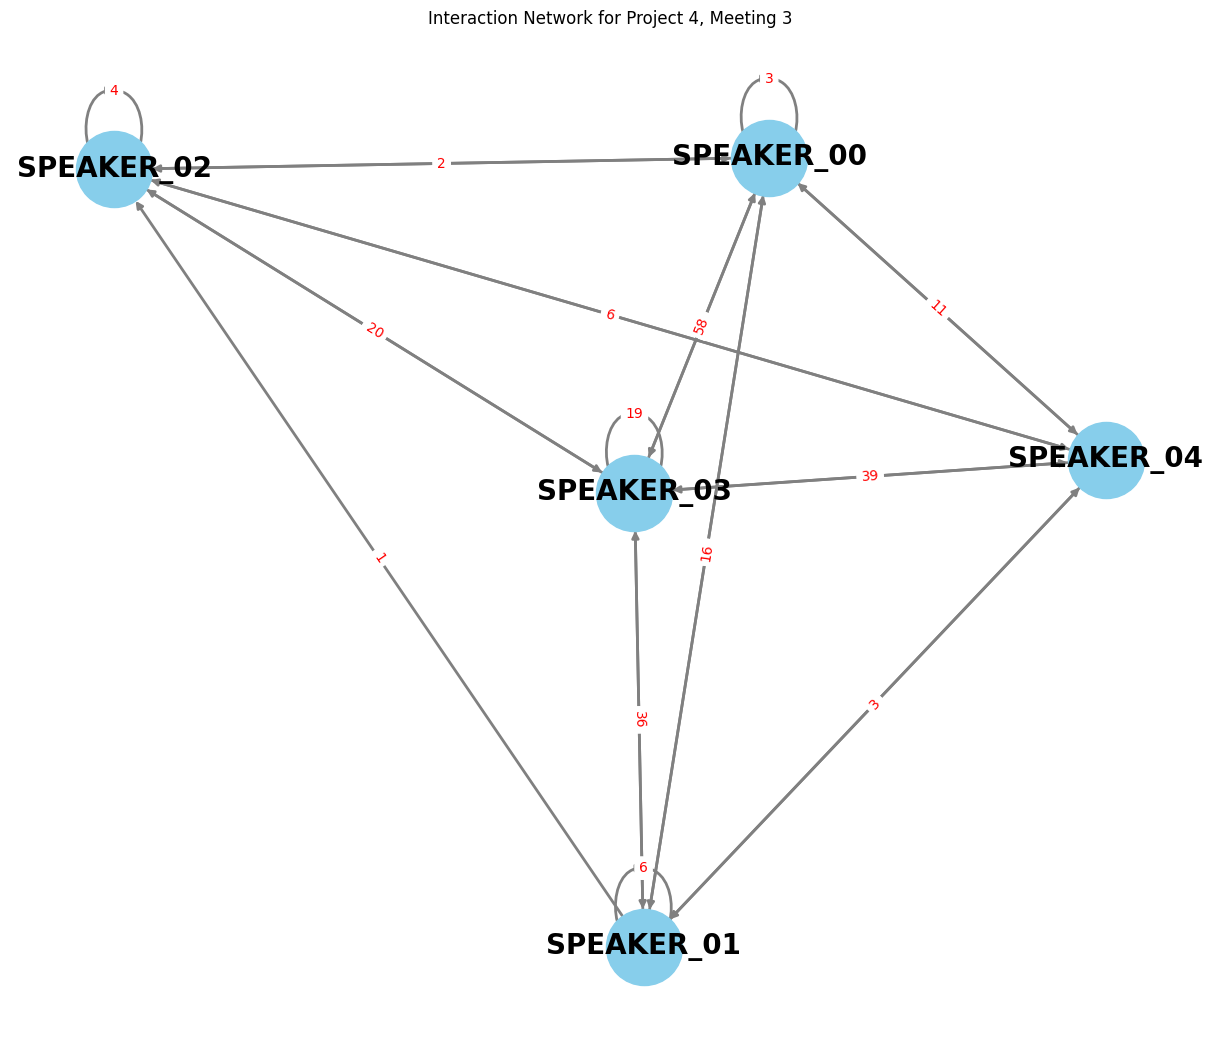

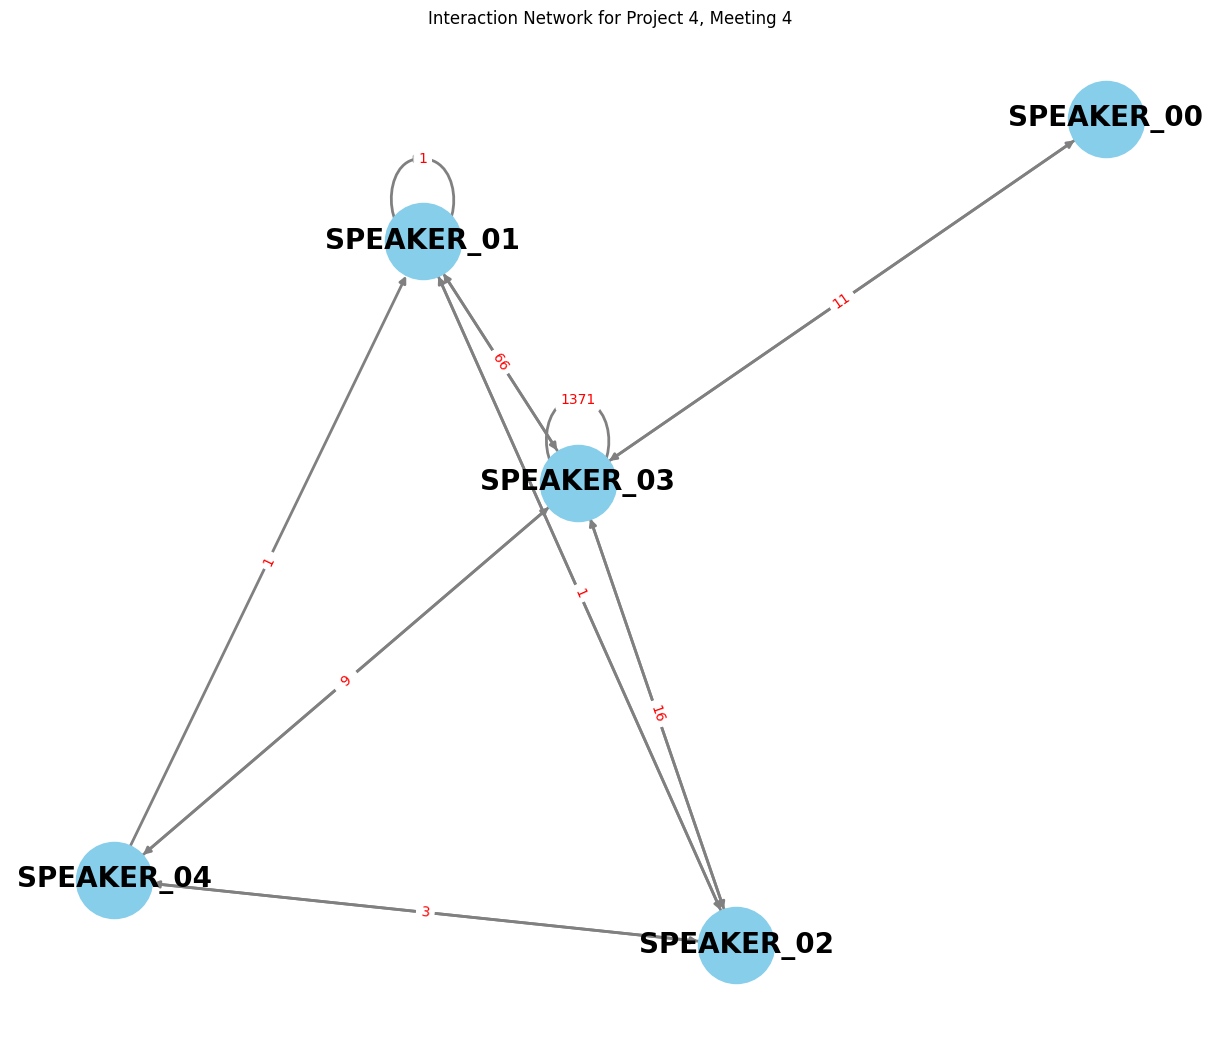

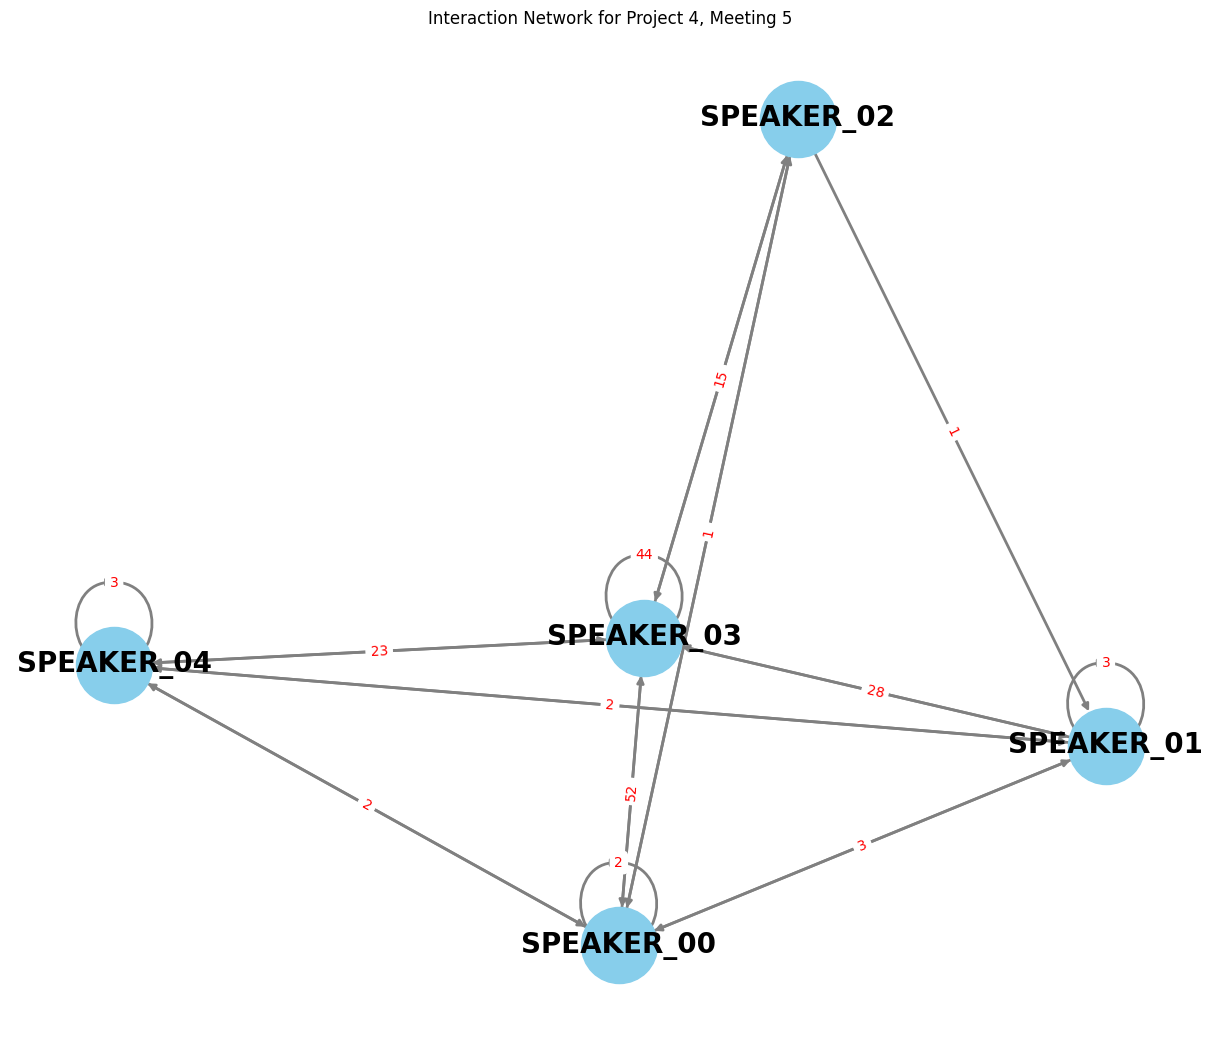

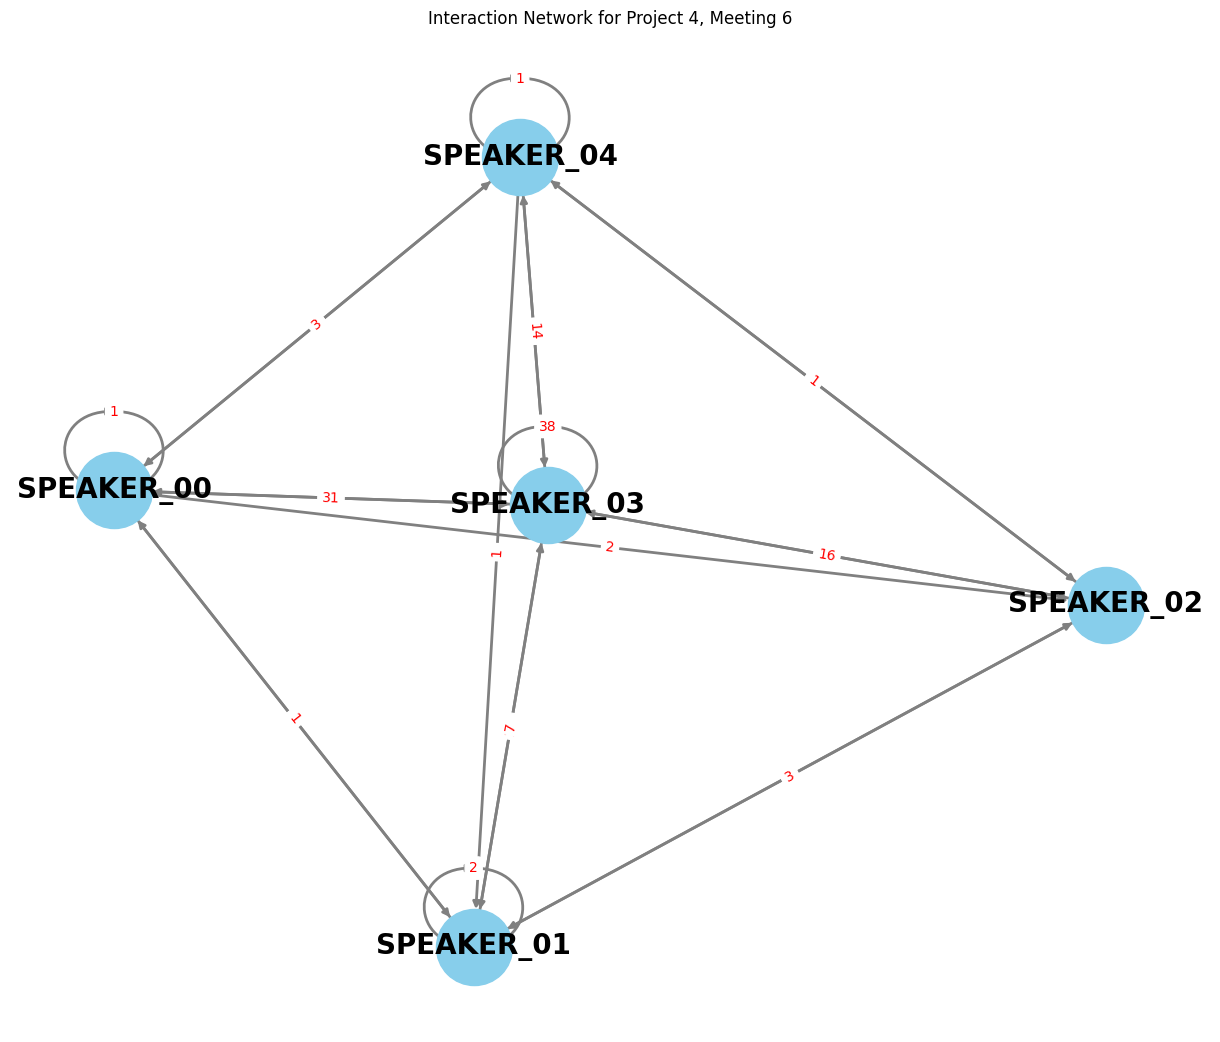

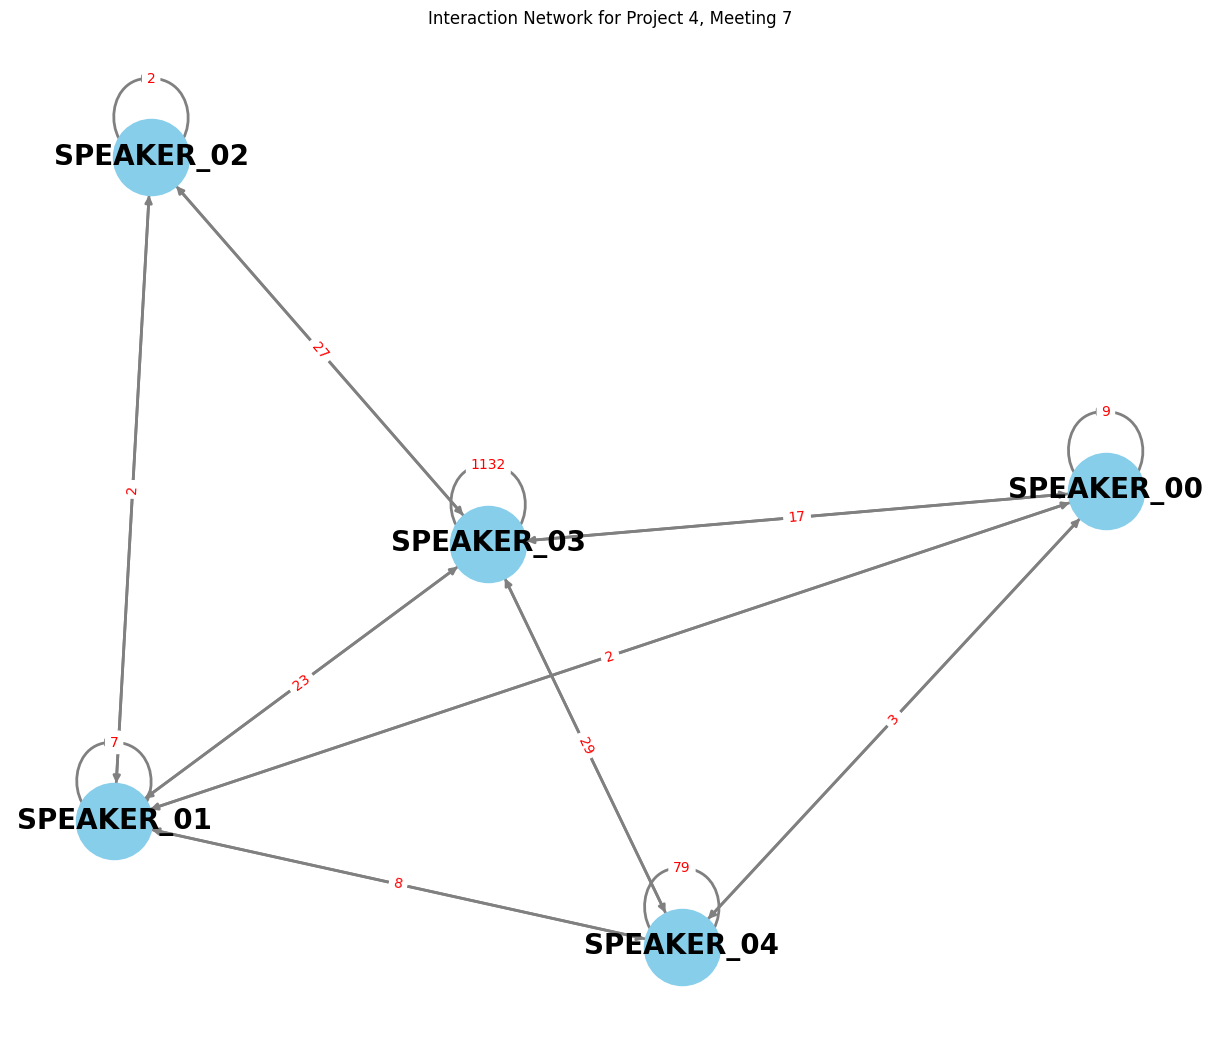

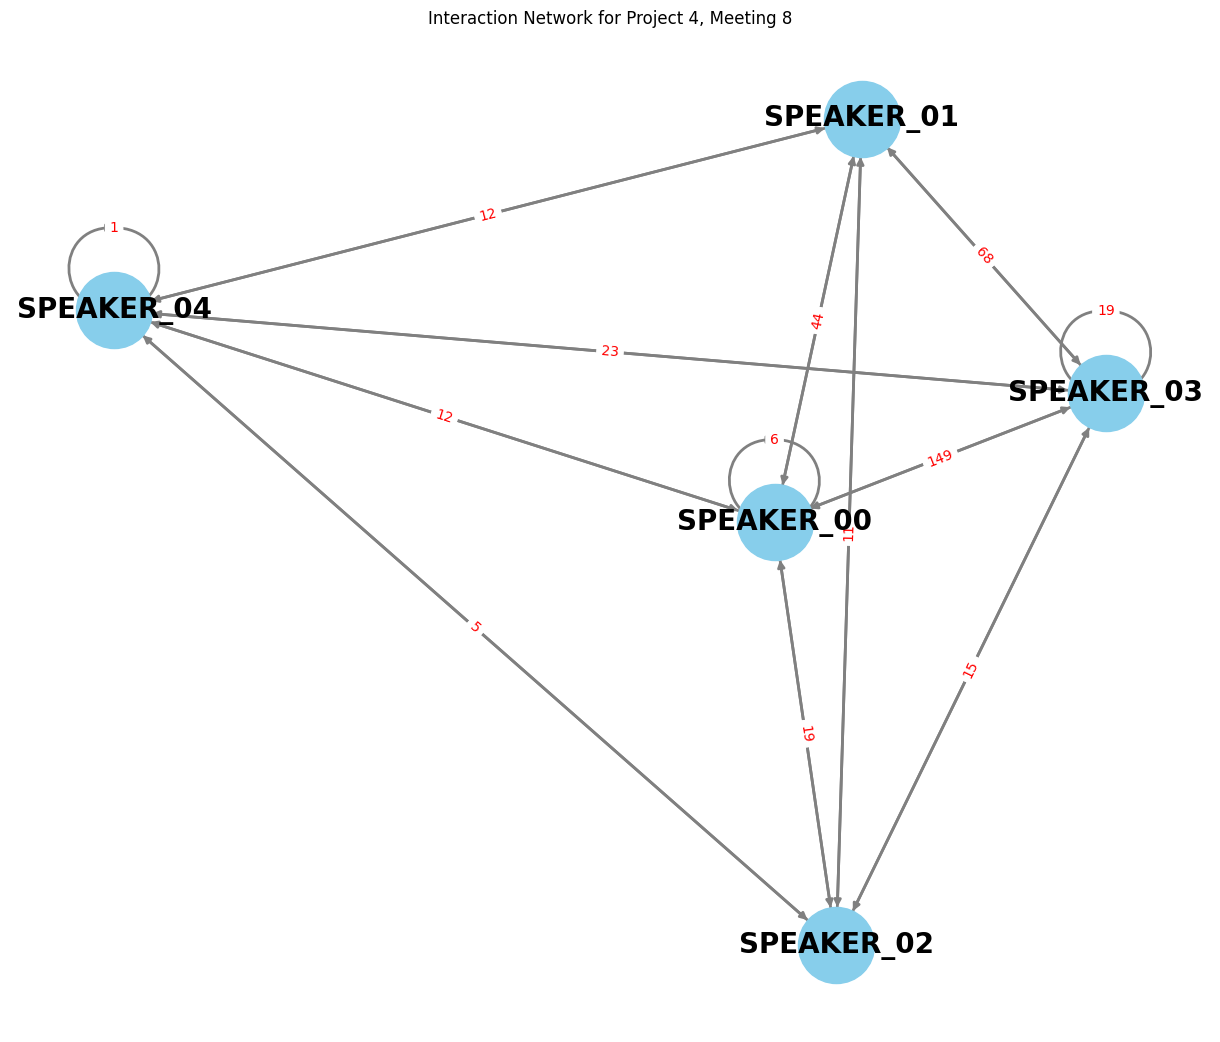

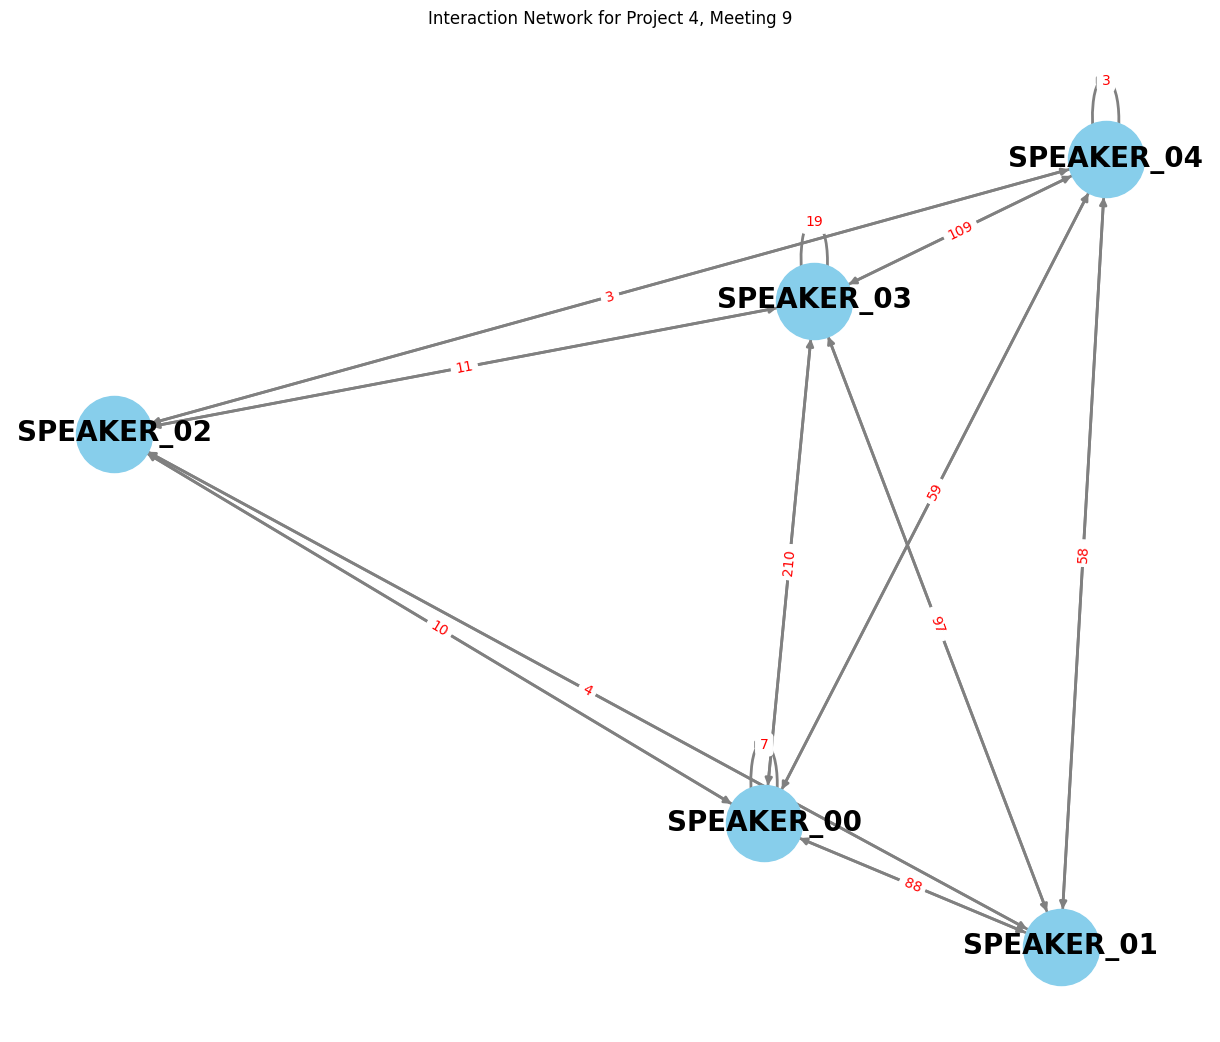

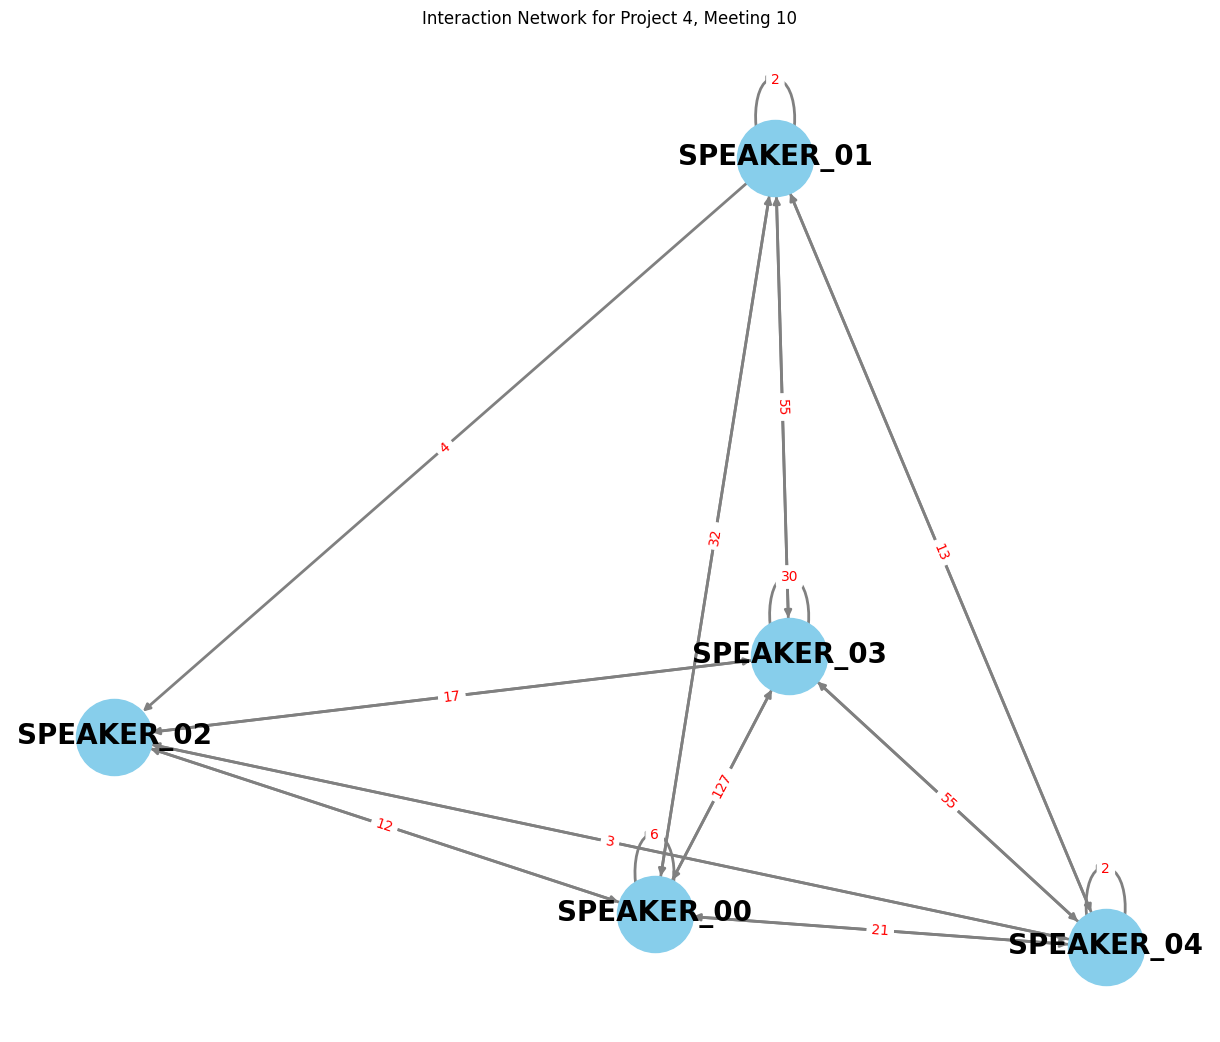

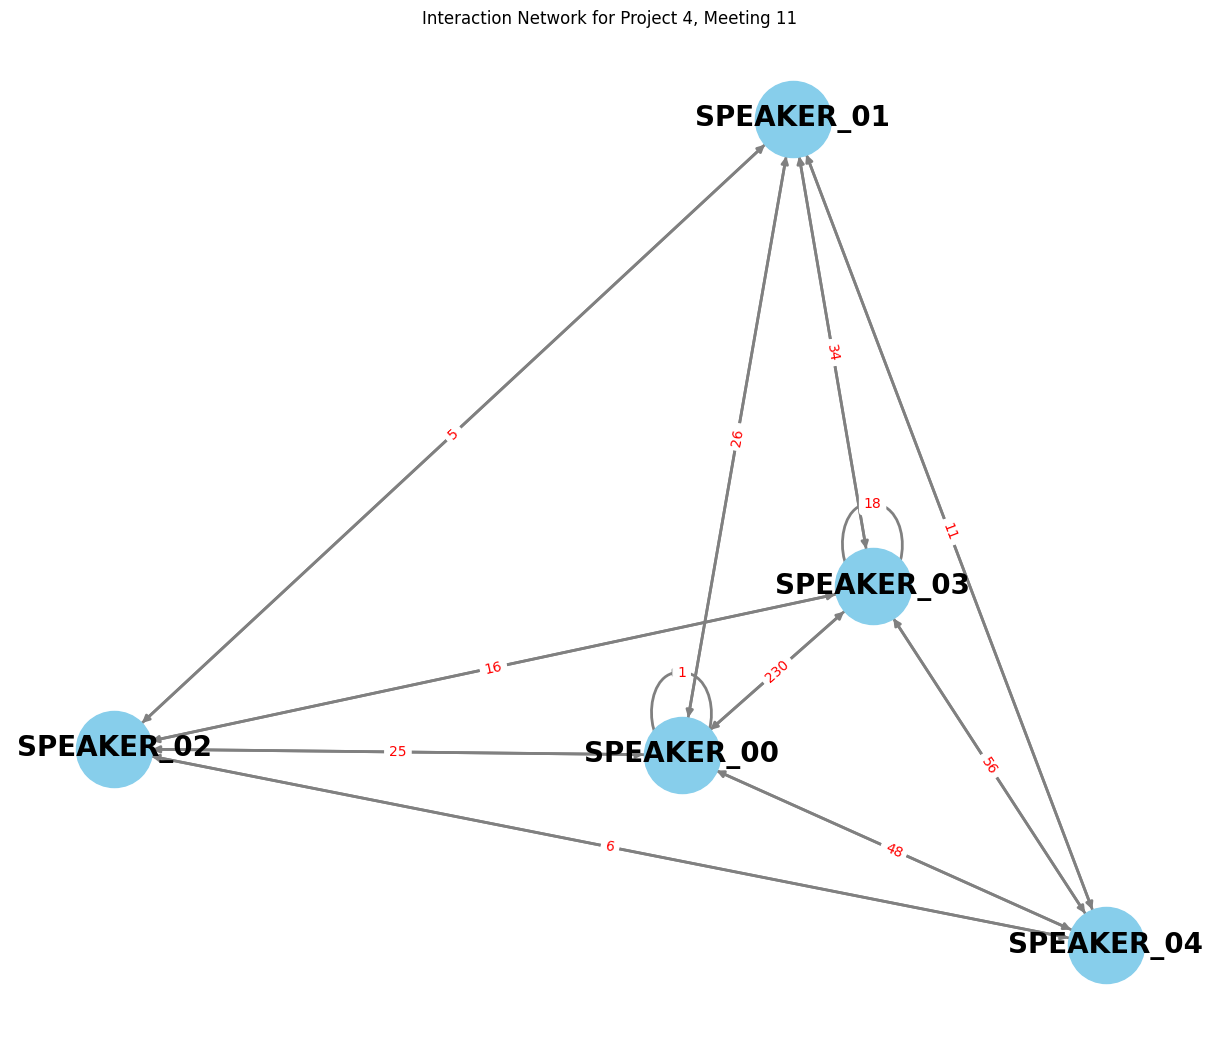

In [326]:
# Create graphs for each meeting
def create_interaction_graphs(df):
    graphs = []
    for meeting_number in df['meeting_number'].unique():
        G = nx.DiGraph()
        meeting_data = df[df['meeting_number'] == meeting_number]
        for i in range(len(meeting_data)):
            prev_speaker = f"SPEAKER_{meeting_data.iloc[i]['speaker_number']:02d}"
            next_speaker = f"SPEAKER_{meeting_data.iloc[i]['next_speaker_id']:02d}"
            if meeting_data.iloc[i]['count'] > 0:
                if G.has_edge(prev_speaker, next_speaker):
                    G[prev_speaker][next_speaker]['weight'] += meeting_data.iloc[i]['count']
                else:
                    G.add_edge(prev_speaker, next_speaker, weight=meeting_data.iloc[i]['count'])
        graphs.append(G)
    return graphs

graphs_project3 = create_interaction_graphs(dataset[dataset['project'] == 3])
graphs_project4 = create_interaction_graphs(dataset[dataset['project'] == 4])

# Plotting Interaction Network Graph
def plot_interaction_network(G, title):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=20, font_color="black", font_weight="bold", width=2, edge_color="gray")
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(title)
    plt.show()

for i, G in enumerate(graphs_project3):
    plot_interaction_network(G, f'Interaction Network for Project 3, Meeting {i+1}')
for i, G in enumerate(graphs_project4):
    plot_interaction_network(G, f'Interaction Network for Project 4, Meeting {i+1}')